In [1]:
from datasets import load_dataset, load_from_disk
from collections import Counter
import functools

D:\Anaconda3\envs\nlp_torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import os
os.chdir('..')
os.getcwd()

In [2]:
# %load_ext autoreload
# %autoreload 2

In [6]:
%run PII_Util.py

# To Basy Py

In [7]:
def col_id2label_base(col_name, model_adapter):
    list_name = col_name.split('_')
    
    
    if list_name[-1].isdigit():
        label_id = int(list_name[-1])
        
        if list_name[0] == 'token':
            list_name[-1] = model_adapter.config.id2label[label_id]
        else:
            list_name[-1] = id2classes[label_id]
        return '_'.join(list_name)
        
    else:
        return col_name

In [8]:
def run_and_compute_metrics(path_dataset, path_preds, model_adapter):
    global df_all_metrics
    
    dataset = load_from_disk(path_dataset)
    np_preds = np.load(path_preds)
    np_labels = pad_lists(dataset['labels'], -100, np_preds.shape[1])
    
    threshold = model_adapter.threshold
    compute_metrics = functools.partial(compute_metrics_base, preprocessed_dataset=dataset, model_adapter=model_adapter, threshold=threshold)
    
    eval_preds = (np_preds, np_labels, None)
    dict_all_scores = compute_metrics(eval_preds)
    
    token_confusion_matrix = dict_all_scores.pop('token_confusion_matrix')
    word_confusion_matrix = dict_all_scores.pop('word_confusion_matrix')
    
    df_all_metrics = pd.DataFrame(dict_all_scores)
    
    col_id2label = functools.partial(col_id2label_base, model_adapter=model_adapter)
    df_all_metrics.columns = df_all_metrics.columns.map(col_id2label)
    df_all_metrics = df_all_metrics.T
    
    return df_all_metrics, token_confusion_matrix, word_confusion_matrix


# Model 1

## Data

In [9]:
%%time
threshold = 0.18
model_adapter_1 = Yanis_Adapter(threshold = threshold, config_only=True, will_bio_tokens=False, will_bio_words=True)
path_dataset_1 = "./in/tokenized_datasets"
path_preds_1 = "./in/preds01.npy"


# preprocessed_dataset = load_from_disk("./in/preprocessed_dataset_2")

CPU times: total: 828 ms
Wall time: 2.01 s


In [10]:
%%time
df_all_metrics_1, token_confusion_matrix_1,  word_confusion_matrix_1 = run_and_compute_metrics(path_dataset_1, path_preds_1, model_adapter_1)

CPU times: total: 1min 7s
Wall time: 1min 31s


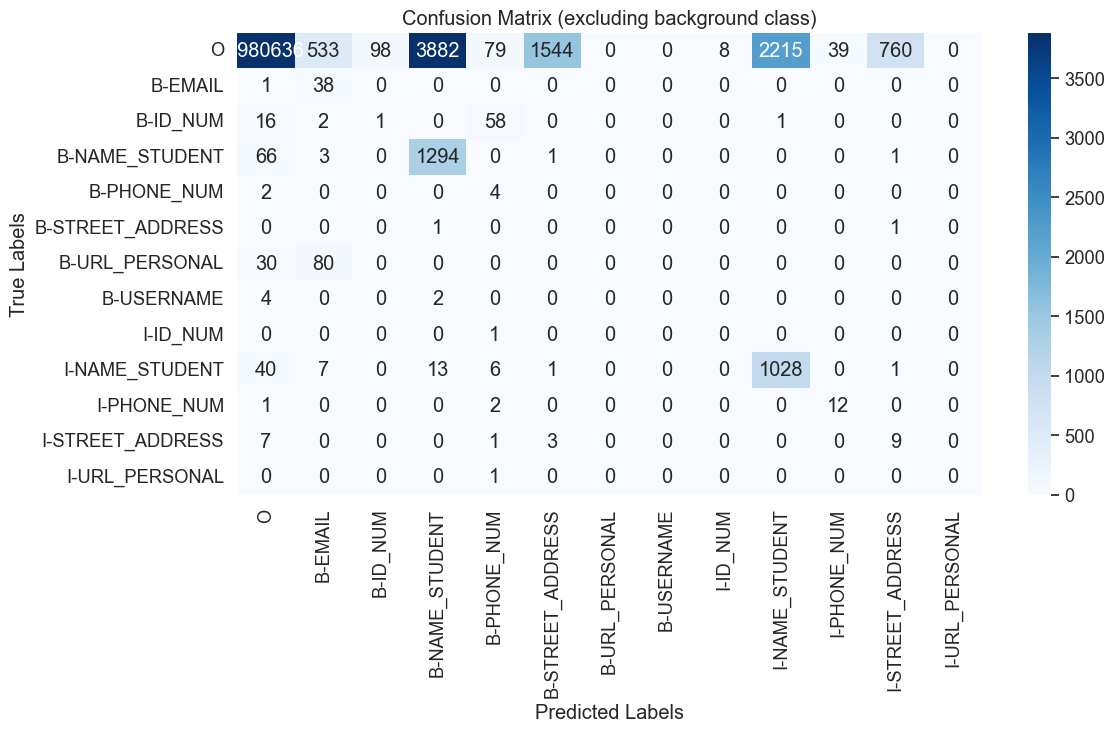

In [8]:
conf_matrix = word_confusion_matrix_1

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)  # Adjust font scale

# Calculate vmin and vmax excluding the background class
vmin = np.min(conf_matrix[conf_matrix != conf_matrix[0,0]])
vmax = np.max(conf_matrix[conf_matrix != conf_matrix[0,0]])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes, vmin=vmin, vmax=vmax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (excluding background class)')
plt.show()

# Model 2

In [9]:
%%time
threshold = 0.01
model_adapter_2 = Yanis_Adapter(threshold = threshold, checkpoint_path='./fine_tuned/yanis/yanis_01',  config_only=True, will_bio_tokens=False, will_bio_words=True)
path_dataset_2 = "./in/preprocessed_dataset_2"
path_preds_2 = ("./in/preds02.npy")


Yanis_Adapter(threshold = 0.1, checkpoint_path='./fine_tuned/yanis/yanis_01',  config_only=True, will_bio_tokens=False, will_bio_words=True)
# preprocessed_dataset = load_from_disk("./in/preprocessed_dataset_2")

CPU times: total: 859 ms
Wall time: 1.43 s


In [10]:
%%time
df_all_metrics_2, token_confusion_matrix_2,  word_confusion_matrix_2 = run_and_compute_metrics(path_dataset_2, path_preds_2, model_adapter_2)

CPU times: total: 1min 7s
Wall time: 1min 25s


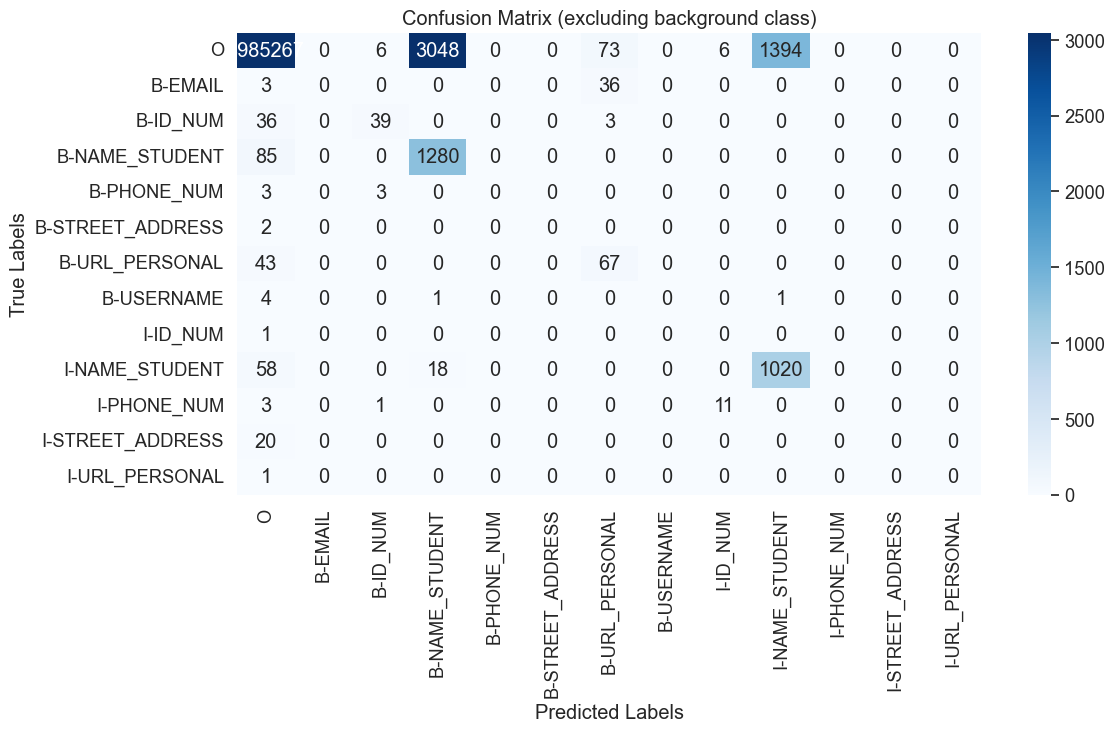

In [11]:
conf_matrix = word_confusion_matrix_2

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)  # Adjust font scale

# Calculate vmin and vmax excluding the background class
vmin = np.min(conf_matrix[conf_matrix != conf_matrix[0,0]])
vmax = np.max(conf_matrix[conf_matrix != conf_matrix[0,0]])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes, vmin=vmin, vmax=vmax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (excluding background class)')
plt.show()

# Comparison

## Confusion matrix diff

### Final

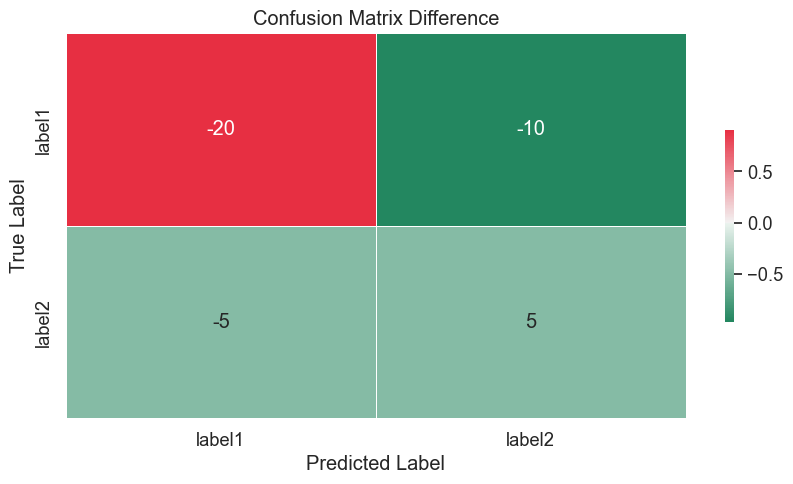

<Axes: title={'center': 'Confusion Matrix Difference'}, xlabel='Predicted Label', ylabel='True Label'>

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_diff_matrix(diff_cm, labels, fmt="d", invert_diagonal = True, invert_colors = True, robust=True):
    # Create a copy of the difference matrix to invert the signs of diagonal elements
    
    if invert_diagonal:
        diff_cm_visual = np.copy(diff_cm)
        np.fill_diagonal(diff_cm_visual, -np.diagonal(diff_cm))
    else:
        diff_cm_visual = diff_cm
    
    positive_values = np.where(diff_cm_visual > 0, diff_cm_visual, 0)
    negative_values = np.where(diff_cm_visual < 0, diff_cm_visual, 0)

    # Normalize positive values to range [0, 1]
    max_positive = np.max(positive_values)
    positive_normalized = np.where(positive_values > 0, positive_values / max_positive, 0)

    # Normalize negative values to range [0, -1]
    min_negative = np.min(negative_values)
    negative_normalized = np.where(negative_values < 0, negative_values / min_negative, 0)

    # Combine positive, negative, and zero values
    data_normalized = positive_normalized - negative_normalized
    
    # Set up the color mapping
#     cmap = sns.diverging_palette(150, 10, as_cmap=True)

    if invert_colors:
        cmap = sns.diverging_palette(150, 10, s=90, l=50, as_cmap=True)
    else:
        cmap = sns.diverging_palette(10, 150, s=90, l=50, as_cmap=True)
    
    # Set up the figure
    plt.figure(figsize=(10, 5))
    
    # Plot the heatmap for the difference matrix with specified color mapping
#     obj = sns.heatmap(diff_cm_visual, annot=diff_cm, robust=True, fmt="d", cmap=cmap, center=0,
#                 linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)
    
#     obj = sns.heatmap(diff_cm_visual, annot=diff_cm, robust=True, fmt="d", cmap=cmap, center = 0,
#             linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)
    
#     obj = sns.heatmap(diff_cm_visual, annot=diff_cm, robust=True, fmt="d", cmap=cmap, center=0, vmin = -799, vmax=100,
#             linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)

#     obj = sns.heatmap(data_normalized, annot=diff_cm, robust=False, fmt="d", cmap=cmap, center=0, vmin = -1, vmax =1,
#         linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)
    
    obj = sns.heatmap(data_normalized, annot=diff_cm, robust=robust, fmt=fmt, cmap=cmap, center=0,
        linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)
    
    
    
    plt.title('Confusion Matrix Difference')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return obj
    

# Example confusion matrices (replace these with your actual confusion matrices)
cm1 = np.array([[120, 20], [30, 50]])
cm2 = np.array([[100, 10], [25, 55]])

diff_cm = cm2 - cm1

visualize_diff_matrix(diff_cm, ['label1', 'label2'])

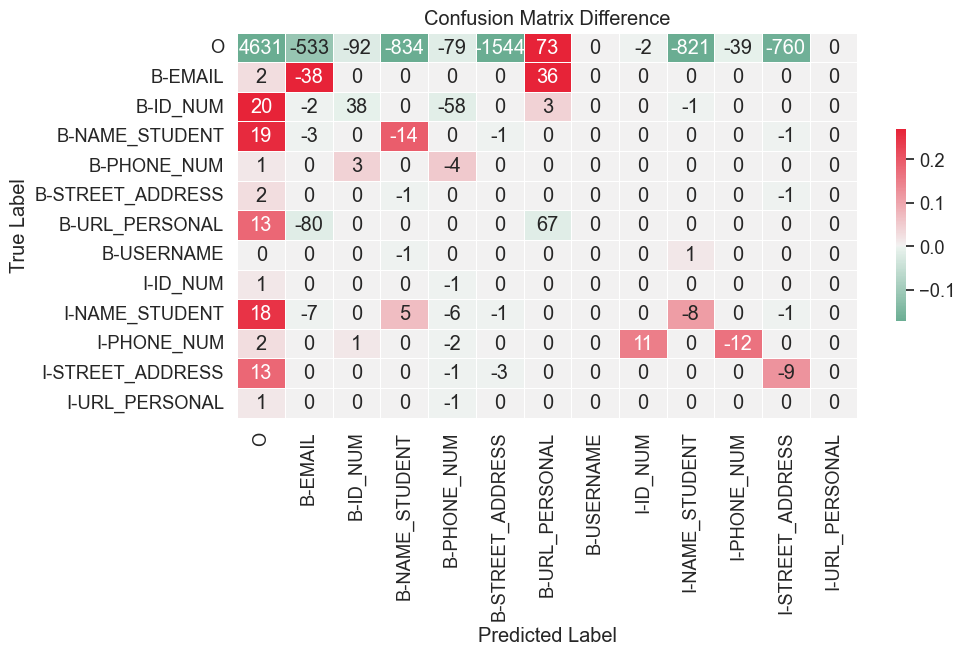

In [14]:
diff_cm = word_confusion_matrix_2 - word_confusion_matrix_1
obj = visualize_diff_matrix(diff_cm, classes)

In [50]:
#conf2 - conf1
#Ask gpt for color map


conf_diff = word_confusion_matrix_2 - word_confusion_matrix_1

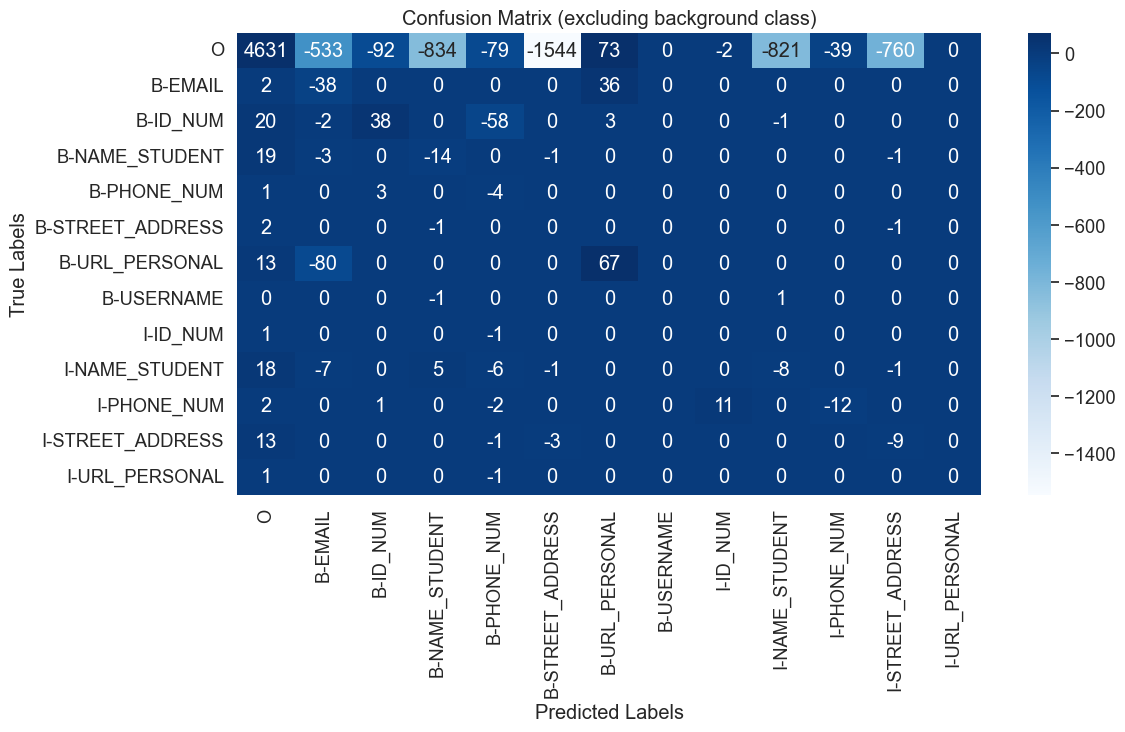

In [52]:
# conf_matrix = np.array([[20, 5, 0],
#                         [3, 25, 2],
#                         [1, 4, 18]])

conf_matrix = conf_diff

# Define class labels
# classes = ['Class 1', 'Class 2', 'Class 3']

# Plot confusion matrix
plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)  # Adjust font scale

# Calculate vmin and vmax excluding the background class
vmin = np.min(conf_matrix[conf_matrix != conf_matrix[0,0]])
vmax = np.max(conf_matrix[conf_matrix != conf_matrix[0,0]])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes, vmin=vmin, vmax=vmax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (excluding background class)')
plt.show()

### Try V1

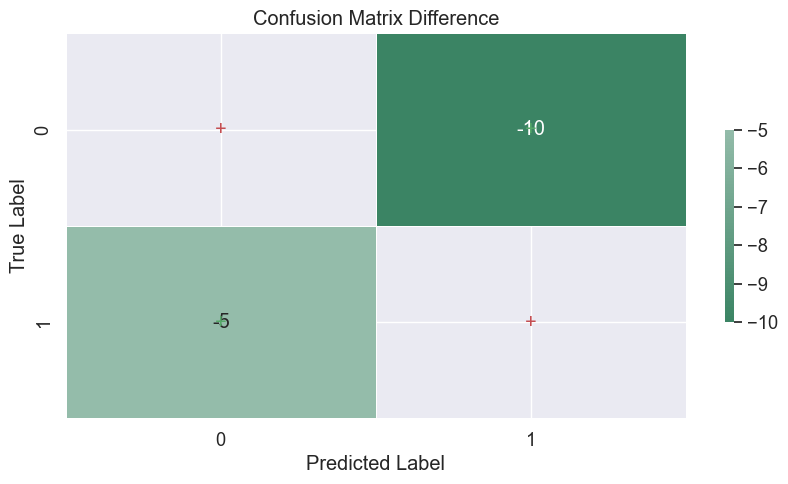

In [53]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_confusion_matrices(cm1, cm2):
    # Calculate the differences between the two confusion matrices
    diff_cm = cm2 - cm1
    
    # Set up the color mapping
    cmap = sns.diverging_palette(150, 10, as_cmap=True)
    
    # Create a mask to highlight diagonal elements
    mask = np.zeros_like(diff_cm, dtype=bool)
    np.fill_diagonal(mask, True)
    
    # Set up the figure
    plt.figure(figsize=(10, 5))
    
    # Plot the heatmap for the difference matrix with specified color mapping
    sns.heatmap(diff_cm, annot=True, fmt="d", cmap=cmap, mask=mask, center=0,
                linewidths=.5, cbar_kws={"shrink": .5})
    
    # Iterate through the cells of the difference matrix to add color according to rules
    for i in range(diff_cm.shape[0]):
        for j in range(diff_cm.shape[1]):
            # For True Positives (diagonal elements)
            if i == j:
                if diff_cm[i, j] > 0:
                    plt.text(j + 0.5, i + 0.5, '+', ha='center', va='center', color='r')
                elif diff_cm[i, j] < 0:
                    plt.text(j + 0.5, i + 0.5, '+', ha='center', va='center', color='g')
            # For False Positives and False Negatives (non-diagonal elements)
            else:
                if diff_cm[i, j] > 0:
                    plt.text(j + 0.5, i + 0.5, '+', ha='center', va='center', color='r')
                elif diff_cm[i, j] < 0:
                    plt.text(j + 0.5, i + 0.5, '+', ha='center', va='center', color='g')
    
    plt.title('Confusion Matrix Difference')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Example confusion matrices (replace these with your actual confusion matrices)
cm1 = np.array([[100, 20], [30, 50]])
cm2 = np.array([[120, 10], [25, 55]])

visualize_confusion_matrices(cm1, cm2)

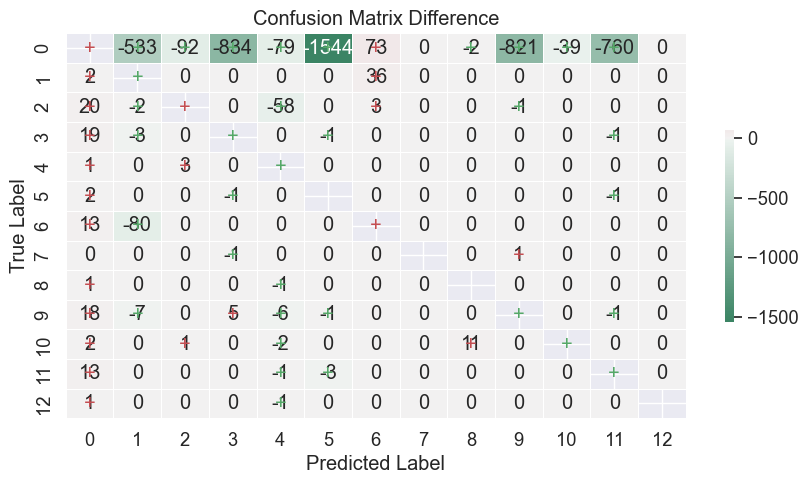

In [54]:
visualize_confusion_matrices(word_confusion_matrix_1, word_confusion_matrix_2)

### Try V2

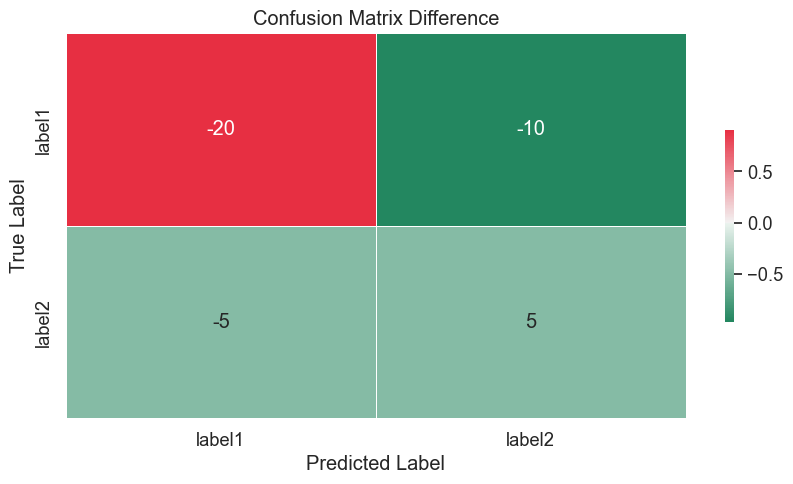

<Axes: title={'center': 'Confusion Matrix Difference'}, xlabel='Predicted Label', ylabel='True Label'>

In [165]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_confusion_matrices(cm1, cm2, labels):
    global data_normalized
    global diff_cm_visual
    
    # Calculate the differences between the two confusion matrices
    diff_cm = cm2 - cm1
    
    # Create a copy of the difference matrix to invert the signs of diagonal elements
    diff_cm_visual = np.copy(diff_cm)
    np.fill_diagonal(diff_cm_visual, -np.diagonal(diff_cm))
    
    positive_values = np.where(diff_cm_visual > 0, diff_cm_visual, 0)
    negative_values = np.where(diff_cm_visual < 0, diff_cm_visual, 0)

    # Normalize positive values to range [0, 1]
    max_positive = np.max(positive_values)
    positive_normalized = np.where(positive_values > 0, positive_values / max_positive, 0)

    # Normalize negative values to range [0, -1]
    min_negative = np.min(negative_values)
    negative_normalized = np.where(negative_values < 0, negative_values / min_negative, 0)

    # Combine positive, negative, and zero values
    data_normalized = positive_normalized - negative_normalized
    
    # Set up the color mapping
#     cmap = sns.diverging_palette(150, 10, as_cmap=True)
    cmap = sns.diverging_palette(150, 10, s=90, l=50, as_cmap=True)
    
    # Set up the figure
    plt.figure(figsize=(10, 5))
    
    # Plot the heatmap for the difference matrix with specified color mapping
#     obj = sns.heatmap(diff_cm_visual, annot=diff_cm, robust=True, fmt="d", cmap=cmap, center=0,
#                 linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)
    
#     obj = sns.heatmap(diff_cm_visual, annot=diff_cm, robust=True, fmt="d", cmap=cmap, center = 0,
#             linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)
    
#     obj = sns.heatmap(diff_cm_visual, annot=diff_cm, robust=True, fmt="d", cmap=cmap, center=0, vmin = -799, vmax=100,
#             linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)

#     obj = sns.heatmap(data_normalized, annot=diff_cm, robust=False, fmt="d", cmap=cmap, center=0, vmin = -1, vmax =1,
#         linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)
    
    obj = sns.heatmap(data_normalized, annot=diff_cm, robust=True, fmt="d", cmap=cmap, center=0,
        linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)
    
    
    
    plt.title('Confusion Matrix Difference')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return obj
    

# Example confusion matrices (replace these with your actual confusion matrices)
cm1 = np.array([[120, 20], [30, 50]])
cm2 = np.array([[100, 10], [25, 55]])

visualize_confusion_matrices(cm1, cm2, ['label1', 'label2'])

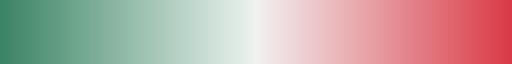

In [88]:
cmap = sns.diverging_palette(150, 10, as_cmap=True)
cmap

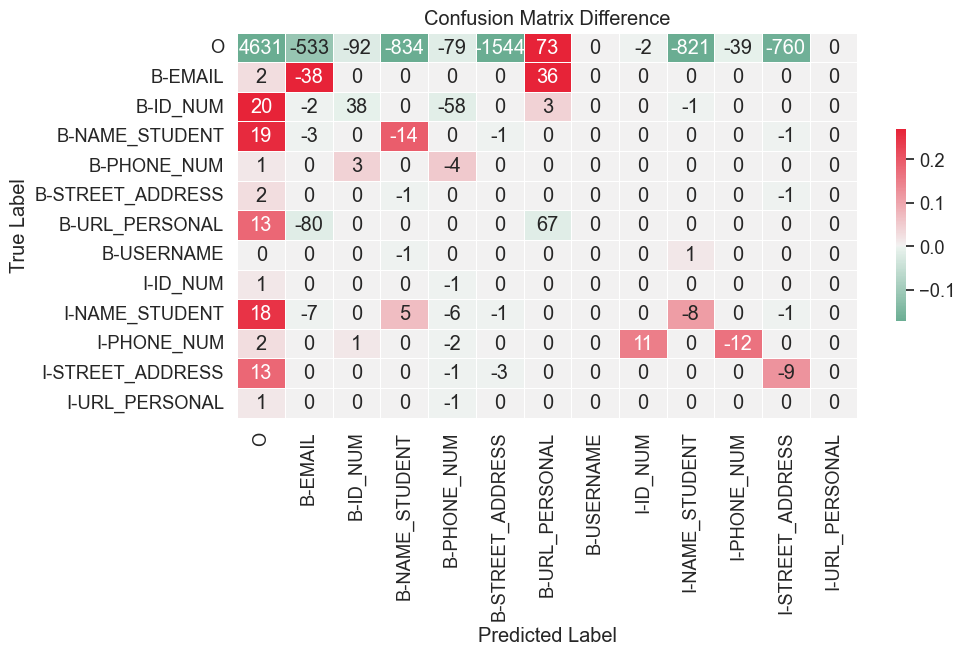

In [166]:
obj = visualize_confusion_matrices(word_confusion_matrix_1, word_confusion_matrix_2, classes)

In [132]:
data_normalized

array([[0.0854854 , 0.13202083, 0.13685503, 0.04319042, 0.17013551,
        0.92487709, 0.46962866, 0.18188433, 0.2111354 , 0.0038749 ],
       [0.0207333 , 0.33405823, 0.0916384 , 0.39245986, 0.019714  ,
        1.        , 0.37662768, 0.13525204, 0.06233767, 0.50854098],
       [0.26260568, 0.1717501 , 0.31774956, 0.12485297, 0.01366336,
        0.01441913, 0.09282264, 0.11088536, 0.01898772, 0.54713824],
       [0.17061803, 0.03585226, 0.17434073, 0.38591211, 0.24783738,
        0.00891629, 0.43528201, 0.25985165, 0.08420078, 0.29014474],
       [0.07585343, 0.33524339, 0.19783769, 0.05917914, 0.49998114,
        0.15948303, 0.19597394, 0.27809523, 0.44408628, 0.35446922],
       [0.55531206, 0.07465088, 0.52182602, 0.57719019, 0.21756629,
        0.02717053, 0.52791743, 0.35505804, 0.63907695, 0.37342731],
       [0.73472533, 0.57496936, 1.        , 0.46553178, 0.28130156,
        0.45360336, 0.64237934, 0.47849517, 0.2616912 , 0.46756795],
       [0.691439  , 0.32136046, 0.6737399

In [112]:
obj.collections[0].get_clim()

(-799.04, 19.639999999999986)

In [90]:
obj.collections[0].get_clim()

(-800.0, 800.0)

### Experiment

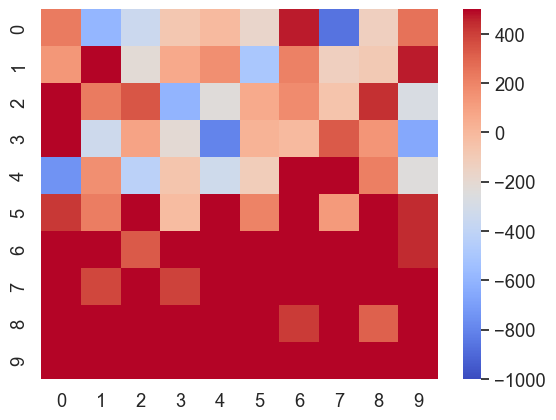

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = np.random.randn(10, 10) * 400
data[5:,:] += 800

# Plot heatmap with asymmetric vmin and vmax
heatmap = sns.heatmap(data, cmap="coolwarm", vmin=-1000, vmax=500)

plt.show()

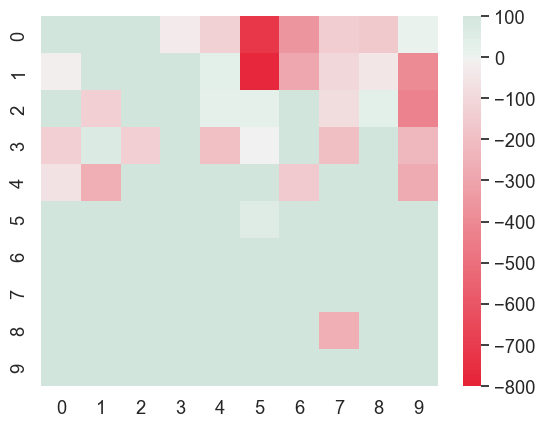

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = np.random.randn(10, 10) * 400
data[5:,:] += 800

# Define custom colormap with enhanced red for positive values
cmap = sns.diverging_palette(10, 150, s=90, l=50, as_cmap=True)

# Plot heatmap with custom colormap and adjusted vmin, vmax, and center
heatmap = sns.heatmap(data, cmap=cmap, center=0, vmin=-800, vmax=100)

plt.show()

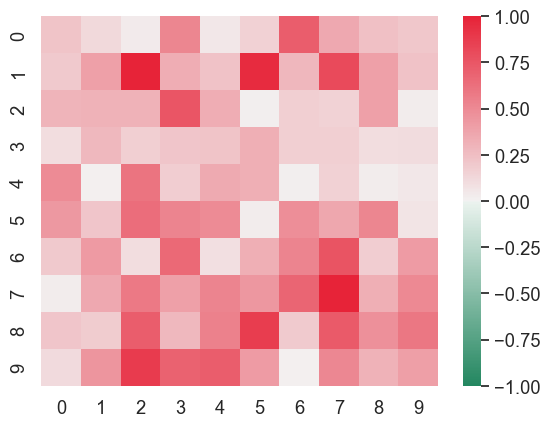

In [137]:
data = np.random.randn(10, 10) * 400
data[5:,:] += 800

# Normalize data to range [0, 1] for positive values and [0, -1] for negative values
data_normalized = np.where(data > 0, data / np.max(data), data / np.min(data))

# Define custom colormap with separate scaling for negative and positive values
cmap = sns.diverging_palette(150, 10, s=90, l=50, as_cmap=True)

# Plot heatmap with custom colormap and adjusted vmin, vmax, and center
heatmap = sns.heatmap(data_normalized, cmap=cmap, center=0, vmin=-1, vmax=1)

plt.show()

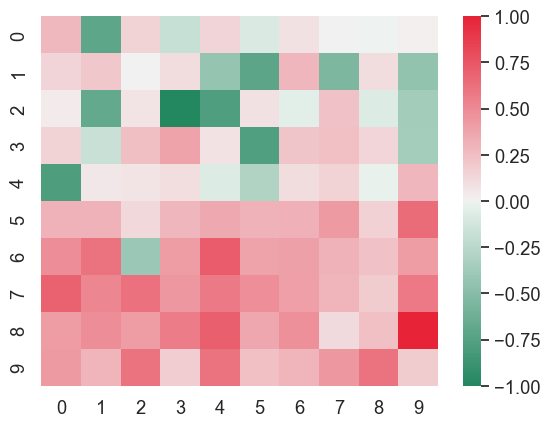

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = np.random.randn(10, 10) * 400
data[5:,:] += 800

# Separate positive, negative, and zero values
positive_values = np.where(data > 0, data, 0)
negative_values = np.where(data < 0, data, 0)

# Normalize positive values to range [0, 1]
max_positive = np.max(positive_values)
positive_normalized = np.where(positive_values > 0, positive_values / max_positive, 0)

# Normalize negative values to range [0, -1]
min_negative = np.min(negative_values)
negative_normalized = np.where(negative_values < 0, negative_values / min_negative, 0)

# Combine positive, negative, and zero values
data_normalized = positive_normalized - negative_normalized
# data_normalized = positive_normalized + negative_normalized

# Define custom colormap with separate scaling for negative and positive values
cmap = sns.diverging_palette(150, 10, s=90, l=50, as_cmap=True)

# Plot heatmap with custom colormap and adjusted vmin, vmax, and center
heatmap = sns.heatmap(data_normalized, cmap=cmap, center=0, vmin=-1, vmax=1)

plt.show()

In [143]:
positive_normalized

array([[0.27408747, 0.        , 0.14969821, 0.        , 0.14763361,
        0.        , 0.08144534, 0.00374203, 0.        , 0.01294308],
       [0.14520873, 0.20375242, 0.00476153, 0.10712806, 0.        ,
        0.        , 0.28605693, 0.        , 0.10887631, 0.        ],
       [0.03455034, 0.        , 0.06404554, 0.        , 0.        ,
        0.08573622, 0.        , 0.2340538 , 0.        , 0.        ],
       [0.15072235, 0.        , 0.24377378, 0.37687351, 0.07451884,
        0.        , 0.21449878, 0.23481486, 0.14038005, 0.        ],
       [0.        , 0.05011121, 0.06689354, 0.10127972, 0.        ,
        0.        , 0.10350335, 0.15422126, 0.        , 0.28812987],
       [0.30742018, 0.31182389, 0.12334334, 0.28522691, 0.35581902,
        0.30679186, 0.31700266, 0.42705901, 0.16217611, 0.64238759],
       [0.49053941, 0.61637302, 0.        , 0.4076355 , 0.72436786,
        0.38773065, 0.39140241, 0.30518876, 0.23067483, 0.40797431],
       [0.68942016, 0.51162772, 0.6235534

In [144]:
negative_normalized

array([[0.        , 0.70712237, 0.        , 0.18473583, 0.        ,
        0.09339984, 0.        , 0.        , 0.00671862, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.43284538,
        0.7121566 , 0.        , 0.54871451, 0.        , 0.45215577],
       [0.        , 0.68291819, 0.        , 1.        , 0.7793378 ,
        0.        , 0.05287996, 0.        , 0.07551618, 0.36537756],
       [0.        , 0.17373902, 0.        , 0.        , 0.        ,
        0.77036141, 0.        , 0.        , 0.        , 0.35218582],
       [0.78211731, 0.        , 0.        , 0.        , 0.07167002,
        0.30160198, 0.        , 0.        , 0.01668292, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.40240609, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

## Metric contribution

### Final

In [15]:
def calculate_total_f_beta(cm, pos_labels, beta=5):
    # Calculate precision and recall across all classes
    global TP, FP, FN
    
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    
    # Calculate total true positives, false positives, and false negatives excluding 'O' label
    total_tp = sum(TP[pos_labels])
    total_fp = sum(FP[pos_labels])
    total_fn = sum(FN[pos_labels])
    
    # Compute total precision excluding 'O' label
    total_precision = total_tp / (total_tp + total_fp) if total_tp + total_fp > 0 else 0
    
    # Compute total recall excluding 'O' label
    total_recall = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0
    
    # Compute total F-beta score excluding 'O' label
    total_f_beta = (1 + beta**2) * (total_precision * total_recall) / (beta**2 * total_precision + total_recall) if total_precision + total_recall > 0 else 0
    
    return total_f_beta


def get_cell_contribution_matrix(cm1, cm2, pos_labels, beta=1):
    f_beta_score_cm1 = calculate_total_f_beta(cm1,pos_labels, beta)
    
    compute_micro_metrics
    
    cell_contribution_matrix = np.zeros_like(cm1, dtype=float)
    
    for i in range(cm1.shape[0]):
        for j in range(cm1.shape[1]):
            # Temporarily modify the corresponding cell in cm1 to match cm2
            cm1_modified = cm1.copy()
            cm1_modified[i, j] = cm2[i, j]
            
            # Calculate the total F-beta score for modified cm1
            f_beta_score_modified = calculate_total_f_beta(cm1_modified, pos_labels,beta)
            
            # Calculate the contribution of changing the current cell
            cell_contribution_matrix[i, j] = f_beta_score_modified - f_beta_score_cm1
    
    return cell_contribution_matrix

# Example usage
cm1 = np.array([[10, 5, 3],
                [2, 20, 1],
                [1, 3, 15]])

cm2 = np.array([[12, 6, 2],
                [1, 21, 1],
                [2, 2, 16]])

num_classes = cm1.shape[0]

contribution_matrix = get_cell_contribution_matrix(cm1, cm2, pos_labels=list(range(num_classes)), beta=1)
print("Contribution Matrix:")
print(contribution_matrix)

Contribution Matrix:
[[ 0.00806452 -0.01229508  0.01271186]
 [ 0.01271186  0.00409836  0.        ]
 [-0.01229508  0.01271186  0.00409836]]


In [16]:
cont_matrix = get_cell_contribution_matrix(word_confusion_matrix_1, word_confusion_matrix_2, pos_labels=classes_pos_id,beta=5)

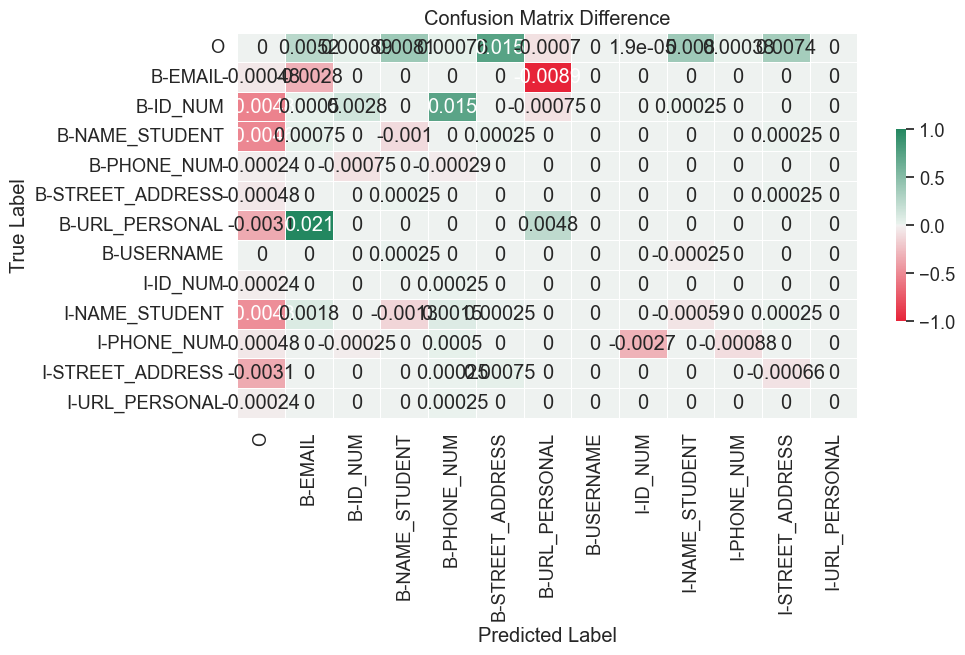

<Axes: title={'center': 'Confusion Matrix Difference'}, xlabel='Predicted Label', ylabel='True Label'>

In [17]:
visualize_diff_matrix(cont_matrix, classes, fmt = '.2g', invert_diagonal=False, invert_colors=False, robust=False)

### Experiment

In [170]:
import numpy as np

def calculate_f_beta(cm, beta=1):
    f_beta_scores = {}
    for class_label in range(num_classes):
        TP = cm[class_label, class_label]
        FP = np.sum(cm[:, class_label]) - TP
        FN = np.sum(cm[class_label, :]) - TP
        
        if TP + FP == 0:
            precision = 0
        else:
            precision = TP / (TP + FP)
        
        if TP + FN == 0:
            recall = 0
        else:
            recall = TP / (TP + FN)
        
        if precision == 0 and recall == 0:
            f_beta = 0
        else:
            f_beta = ((1 + beta**2) * precision * recall) / ((beta**2 * precision) + recall)
        
        f_beta_scores[class_label] = f_beta
    
    return f_beta_scores

def get_cell_contribution(cm1, cm2, beta=1):
    diff_cm = cm2 - cm1
    
    f_beta_scores_cm1 = calculate_f_beta(cm1, beta)
    f_beta_scores_cm2 = calculate_f_beta(cm2, beta)
    
    cell_contributions = {}
    
    for class_label in range(num_classes):
        cell_contributions[class_label] = f_beta_scores_cm2[class_label] - f_beta_scores_cm1[class_label]
    
    return cell_contributions

# Example usage
cm1 = np.array([[10, 5, 3],
                [2, 20, 1],
                [1, 3, 15]])

cm2 = np.array([[12, 6, 2],
                [1, 21, 1],
                [2, 2, 16]])

num_classes = cm1.shape[0]

cell_contributions = get_cell_contribution(cm1, cm2, beta=1)
print("Cell contributions:", cell_contributions)


Cell contributions: {0: 0.04055299539170509, 1: 0.02337858220211153, 2: 0.031039136302294157}


In [173]:
def get_cell_contribution_matrix(cm1, cm2, beta=1):
    diff_cm = cm2 - cm1
    
    f_beta_scores_cm1 = calculate_f_beta(cm1, beta)
    f_beta_scores_cm2 = calculate_f_beta(cm2, beta)
    
    cell_contribution_matrix = np.zeros_like(diff_cm, dtype=float)
    
    for i in range(diff_cm.shape[0]):
        for j in range(diff_cm.shape[1]):
            # Calculate the change in F-beta score for the corresponding cell
            cell_contribution_matrix[i, j] = f_beta_scores_cm2[i] - f_beta_scores_cm1[i]
    
    return cell_contribution_matrix

# Example usage
cm1 = np.array([[10, 5, 3],
                [2, 20, 1],
                [1, 3, 15]])

cm2 = np.array([[12, 6, 2],
                [1, 21, 1],
                [2, 2, 16]])

num_classes = cm1.shape[0]

contribution_matrix = get_cell_contribution_matrix(cm1, cm2, beta=1)
print("Contribution Matrix:")
print(contribution_matrix)

Contribution Matrix:
[[0.040553   0.040553   0.040553  ]
 [0.02337858 0.02337858 0.02337858]
 [0.03103914 0.03103914 0.03103914]]


In [172]:
num_classes = len(classes)
get_cell_contribution(word_confusion_matrix_1, word_confusion_matrix_2, 5)

{0: 0.0008917829822726597,
 1: -0.6031746031746031,
 2: 0.49456451017114217,
 3: 0.0093334379053428,
 4: -0.3443708609271523,
 5: 0,
 6: 0.5947422328439741,
 7: 0,
 8: 0,
 9: 0.01727526420759906,
 10: -0.7323943661971832,
 11: -0.1839622641509434,
 12: 0}

In [176]:
num_classes = len(classes)
cont_matrix = get_cell_contribution_matrix(word_confusion_matrix_1, word_confusion_matrix_2, 5)

<Axes: >

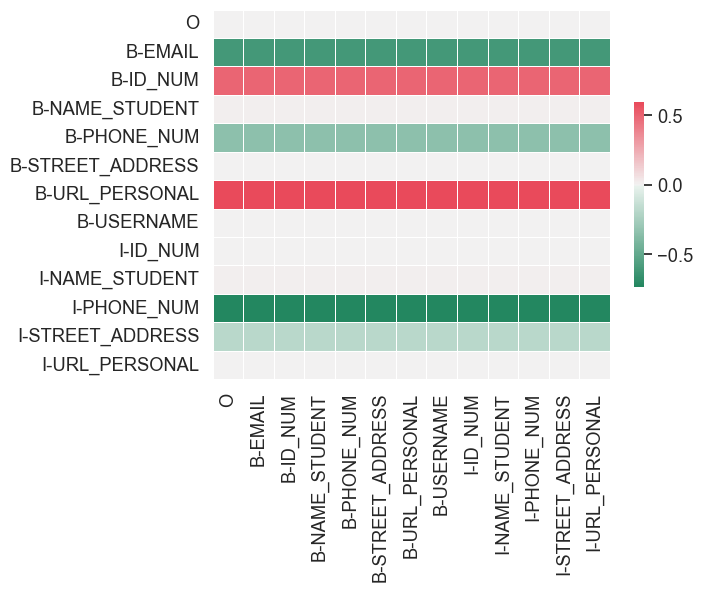

In [178]:
sns.heatmap(cont_matrix, robust=True, fmt="d", cmap=cmap, center=0,
        linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=classes, yticklabels=classes)
    

In [179]:
def get_cell_contribution_matrix(cm1, cm2, beta=1):
    diff_cm = cm2 - cm1
    
    f_beta_scores_cm1 = calculate_f_beta(cm1, beta)
    f_beta_scores_cm2 = calculate_f_beta(cm2, beta)
    
    cell_contribution_matrix = np.zeros_like(diff_cm, dtype=float)
    
    for i in range(diff_cm.shape[0]):
        for j in range(diff_cm.shape[1]):
            # Calculate the change in F-beta score for the corresponding cell
            cell_cm1 = np.zeros_like(cm1)
            cell_cm2 = np.zeros_like(cm2)
            cell_cm1[i, j] = cm1[i, j]
            cell_cm2[i, j] = cm2[i, j]
            cell_contribution_matrix[i, j] = calculate_f_beta(cell_cm2, beta)[i] - calculate_f_beta(cell_cm1, beta)[i]
    
    return cell_contribution_matrix

# Example usage
cm1 = np.array([[10, 5, 3],
                [2, 20, 1],
                [1, 3, 15]])

cm2 = np.array([[12, 6, 2],
                [1, 21, 1],
                [2, 2, 16]])

num_classes = cm1.shape[0]

contribution_matrix = get_cell_contribution_matrix(cm1, cm2, beta=1)
print("Contribution Matrix:")
print(contribution_matrix)

Contribution Matrix:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [184]:
num_classes = len(classes)
cont_matrix = get_cell_contribution_matrix(word_confusion_matrix_1, word_confusion_matrix_2, 5)

In [186]:
cont_matrix

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

<Axes: >

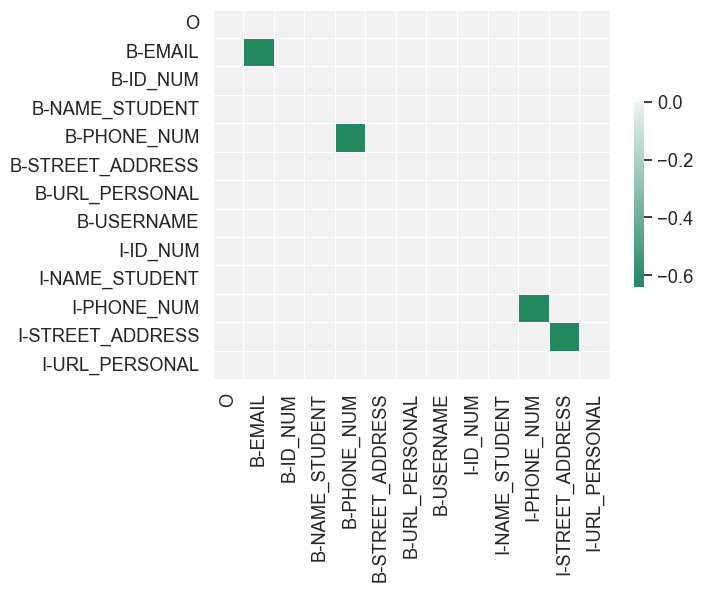

In [185]:
sns.heatmap(cont_matrix, robust=True, fmt="d", cmap=cmap, center=0,
        linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=classes, yticklabels=classes)
    

In [183]:
def get_cell_contribution_matrix(cm1, cm2, beta=1):
    diff_cm = cm2 - cm1
    
    f_beta_scores_cm1 = calculate_f_beta(cm1, beta)
    f_beta_scores_cm2 = calculate_f_beta(cm2, beta)
    
    cell_contribution_matrix = np.zeros_like(diff_cm, dtype=float)
    
    for i in range(diff_cm.shape[0]):
        for j in range(diff_cm.shape[1]):
            # Calculate the change in F-beta score for the corresponding cell
            cell_cm1 = np.zeros_like(cm1)
            cell_cm2 = np.zeros_like(cm2)
            cell_cm1[i, j] = cm1[i, j]
            cell_cm2[i, j] = cm2[i, j]
            cell_contribution_matrix[i, j] = calculate_f_beta(cell_cm2, beta)[i] - calculate_f_beta(cell_cm1, beta)[i]
    
    return cell_contribution_matrix

# Example usage
cm1 = np.array([[10, 5, 3],
                [2, 20, 1],
                [1, 3, 15]])

cm2 = np.array([[12, 6, 2],
                [1, 21, 1],
                [2, 2, 16]])

num_classes = cm1.shape[0]

contribution_matrix = get_cell_contribution_matrix(cm1, cm2, beta=1)
print("Contribution Matrix:")
print(contribution_matrix)

Contribution Matrix:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [187]:
def get_cell_contribution_matrix(cm1, cm2, beta=1):
    f_beta_scores_cm1 = calculate_f_beta(cm1, beta)
    f_beta_scores_cm2 = calculate_f_beta(cm2, beta)
    
    cell_contribution_matrix = np.zeros_like(cm1, dtype=float)
    
    for i in range(cm1.shape[0]):
        for j in range(cm1.shape[1]):
            # Temporarily modify the corresponding cell in cm1 to match cm2
            cm1_modified = cm1.copy()
            cm1_modified[i, j] = cm2[i, j]
            
            # Calculate the F-beta score for modified cm1
            f_beta_score_modified = calculate_f_beta(cm1_modified, beta)[i]
            
            # Calculate the contribution of changing the current cell
            cell_contribution_matrix[i, j] = f_beta_score_modified - f_beta_scores_cm1[i]
    
    return cell_contribution_matrix

# Example usage
cm1 = np.array([[10, 5, 3],
                [2, 20, 1],
                [1, 3, 15]])

cm2 = np.array([[12, 6, 2],
                [1, 21, 1],
                [2, 2, 16]])

num_classes = cm1.shape[0]

contribution_matrix = get_cell_contribution_matrix(cm1, cm2, beta=1)
print("Contribution Matrix:")
print(contribution_matrix)

Contribution Matrix:
[[ 0.040553   -0.02016129  0.02150538]
 [ 0.01568627  0.0081391   0.        ]
 [-0.02024291  0.02133713  0.01052632]]


In [206]:
num_classes = len(classes)
cont_matrix = get_cell_contribution_matrix(word_confusion_matrix_1, word_confusion_matrix_2, beta=5)

In [189]:
cont_matrix

array([[ 1.63776206e-06,  1.02545888e-04,  1.76987240e-05,
         1.60465727e-04,  1.51977793e-05,  2.97113899e-04,
        -1.40431062e-05,  0.00000000e+00,  3.84748196e-07,
         1.57964066e-04,  7.50264332e-06,  1.46225675e-04,
         0.00000000e+00],
       [-1.78665463e-02, -6.03174603e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.13891703e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.48903818e-03,  3.17386609e-04,  3.21193004e-01,
         0.00000000e+00,  3.07165595e-02,  0.00000000e+00,
        -4.48062028e-04,  0.00000000e+00,  0.00000000e+00,
         1.56733160e-04,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.02146877e-02,  1.63545042e-03,  0.00000000e+00,
        -1.34831971e-03,  0.00000000e+00,  5.44456422e-04,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e

<Axes: >

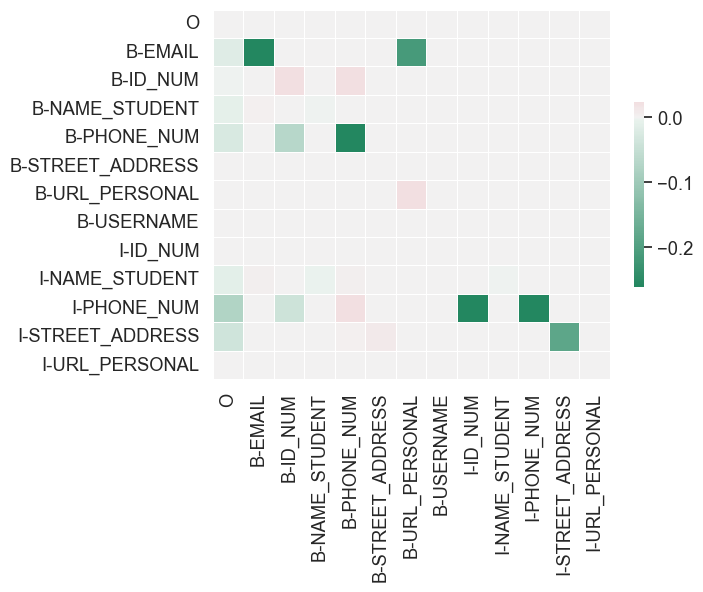

In [207]:
sns.heatmap(cont_matrix, robust=True, fmt="d", cmap=cmap, center=0,
        linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=classes, yticklabels=classes)
    

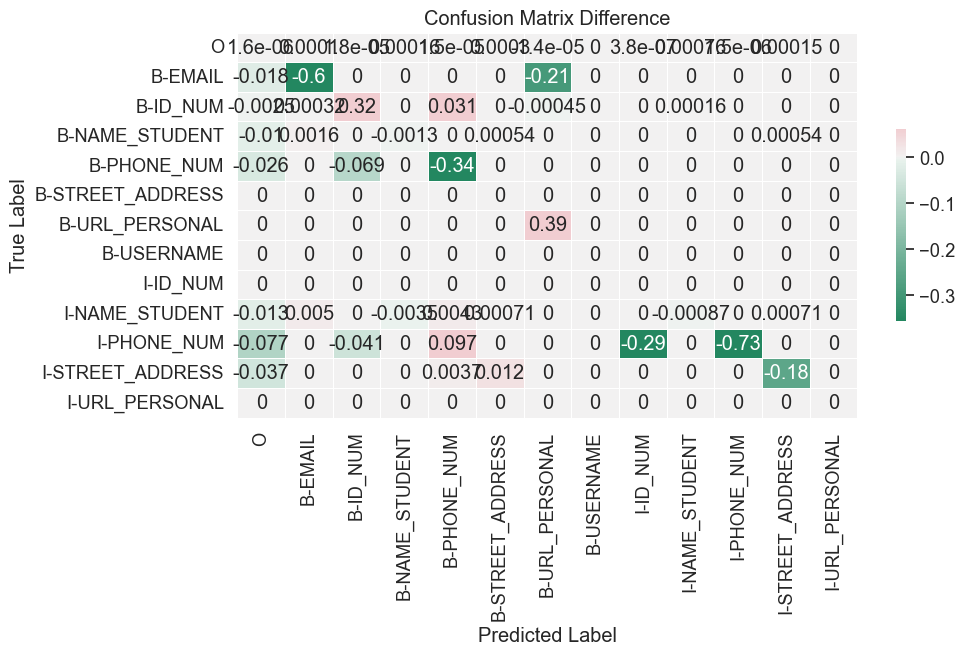

<Axes: title={'center': 'Confusion Matrix Difference'}, xlabel='Predicted Label', ylabel='True Label'>

In [208]:
visualize_diff_matrix(cont_matrix, classes, fmt='.2g', invert_diagonal=False)

In [256]:
def calculate_total_f_beta(cm, pos_labels, beta=5):
    # Calculate precision and recall across all classes
    global TP, FP, FN
    
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    
    # Calculate total true positives, false positives, and false negatives excluding 'O' label
    total_tp = sum(TP[pos_labels])
    total_fp = sum(FP[pos_labels])
    total_fn = sum(FN[pos_labels])
    
    # Compute total precision excluding 'O' label
    total_precision = total_tp / (total_tp + total_fp) if total_tp + total_fp > 0 else 0
    
    # Compute total recall excluding 'O' label
    total_recall = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0
    
    # Compute total F-beta score excluding 'O' label
    total_f_beta = (1 + beta**2) * (total_precision * total_recall) / (beta**2 * total_precision + total_recall) if total_precision + total_recall > 0 else 0
    
    return total_f_beta


def get_cell_contribution_matrix(cm1, cm2, pos_labels, beta=1):
    f_beta_score_cm1 = calculate_total_f_beta(cm1,pos_labels, beta)
    
    compute_micro_metrics
    
    cell_contribution_matrix = np.zeros_like(cm1, dtype=float)
    
    for i in range(cm1.shape[0]):
        for j in range(cm1.shape[1]):
            # Temporarily modify the corresponding cell in cm1 to match cm2
            cm1_modified = cm1.copy()
            cm1_modified[i, j] = cm2[i, j]
            
            # Calculate the total F-beta score for modified cm1
            f_beta_score_modified = calculate_total_f_beta(cm1_modified, pos_labels,beta)
            
            # Calculate the contribution of changing the current cell
            cell_contribution_matrix[i, j] = f_beta_score_modified - f_beta_score_cm1
    
    return cell_contribution_matrix

# Example usage
cm1 = np.array([[10, 5, 3],
                [2, 20, 1],
                [1, 3, 15]])

cm2 = np.array([[12, 6, 2],
                [1, 21, 1],
                [2, 2, 16]])

num_classes = cm1.shape[0]

contribution_matrix = get_cell_contribution_matrix(cm1, cm2, pos_labels=list(range(num_classes)), beta=1)
print("Contribution Matrix:")
print(contribution_matrix)

Contribution Matrix:
[[ 0.00806452 -0.01229508  0.01271186]
 [ 0.01271186  0.00409836  0.        ]
 [-0.01229508  0.01271186  0.00409836]]


In [225]:
sum(TP[list(range(num_classes))])

47

In [223]:
TP

array([12, 20, 15])

In [214]:
cont_matrix.sum()

nan

In [228]:
num_classes = len(classes)
cont_matrix = get_cell_contribution_matrix(word_confusion_matrix_1, word_confusion_matrix_2, pos_labels=classes_pos_id,beta=5)

<Axes: >

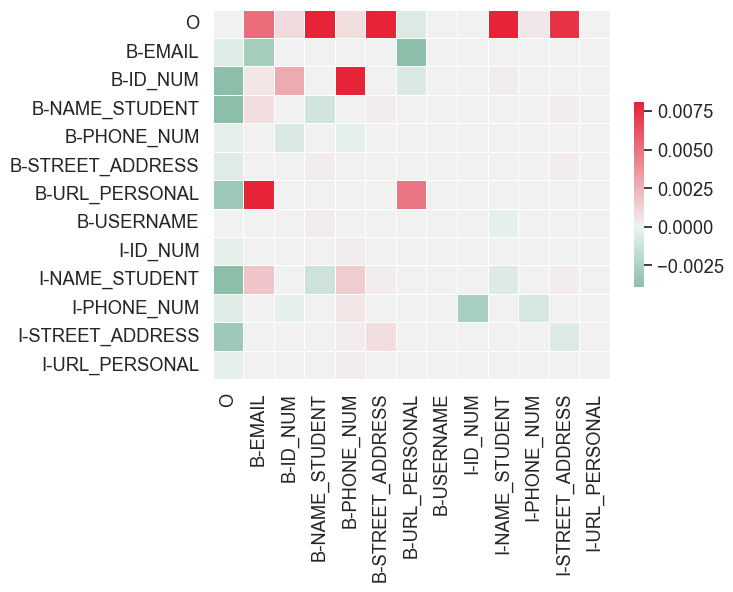

In [229]:
sns.heatmap(cont_matrix, robust=True, fmt="d", cmap=cmap, center=0,
        linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=classes, yticklabels=classes)
    

In [232]:
cont_matrix.sum()

0.053458419252447986

In [250]:
diff_fbeta = df_all_metrics_2.f_beta.word_total_metrics - df_all_metrics_1.f_beta.word_total_metrics
diff_fbeta

0.05528588681601687

In [251]:
diff_fbeta - cont_matrix.sum()

0.0018274675635688853

In [ ]:
df_all_metrics_2.f_beta.word_total_metrics - df_all_metrics_1.f_beta.word_total_metrics

In [237]:
np.argsort(cont_matrix, axis = None)

array([ 19,  26,  39, 117, 143,  78,  14, 138, 120,  42, 140,  54,  32,
         6, 154, 126, 130,  65,  13,  56, 100, 132,  52, 156, 104, 116,
       115,  97, 114,  88, 113, 112, 111, 110, 109,  93,  89, 107,  95,
       106, 105,  90,  91,  98, 103, 102, 101,  92,  99,  96,   0, 123,
       166, 165, 164, 163, 162, 161, 159, 158, 157, 155, 153, 152, 151,
       150, 149, 146, 145, 124, 125, 127,  87, 129, 131, 119, 133, 136,
       137, 139, 141, 142, 144, 135,  86, 168, 167,  49,  48,  47,  46,
        45,  85,  41,  38,  37,  36,  34,  33,  51,  31,  25,  24,  23,
        22,  21,  20,  18,  17,  16,  15,  12,   7,  29,  53,  43,  57,
        80,  75,  74,  73,  72,  55,  81,  71,  82,  70,  69,  66,  64,
        67,  63,  83,  58,  59,  61,  62,  60,  77,   8,  44, 108,  35,
       122, 160,  76, 128, 147,  50,  94,  68,  10,  27, 134, 148,  40,
         4,   2, 121, 118,  28,  84,   1,  11,   9,   3,  30,   5,  79],
      dtype=int64)

In [239]:
pd.DataFrame(cont_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.000000,0.005174,0.000888,0.008127,0.000763,0.015182,-0.000703,0.0,0.000019,0.007999,0.000376,0.007399,0.0
1,-0.000482,-0.002825,0.000000,0.000000,0.000000,0.000000,-0.008922,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,-0.004792,0.000502,0.002757,0.000000,0.014821,0.000000,-0.000751,0.0,0.000000,0.000251,0.000000,0.000000,0.0
3,-0.004554,0.000753,0.000000,-0.001033,0.000000,0.000251,0.000000,0.0,0.000000,0.000000,0.000000,0.000251,0.0
4,-0.000241,0.000000,-0.000751,0.000000,-0.000294,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
5,-0.000482,0.000000,0.000000,0.000251,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000251,0.0
6,-0.003122,0.020593,0.000000,0.000000,0.000000,0.000000,0.004816,0.0,0.000000,0.000000,0.000000,0.000000,0.0
7,0.000000,0.000000,0.000000,0.000251,0.000000,0.000000,0.000000,0.0,0.000000,-0.000251,0.000000,0.000000,0.0
8,-0.000241,0.000000,0.000000,0.000000,0.000251,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
9,-0.004315,0.001759,0.000000,-0.001252,0.001507,0.000251,0.000000,0.0,0.000000,-0.000589,0.000000,0.000251,0.0


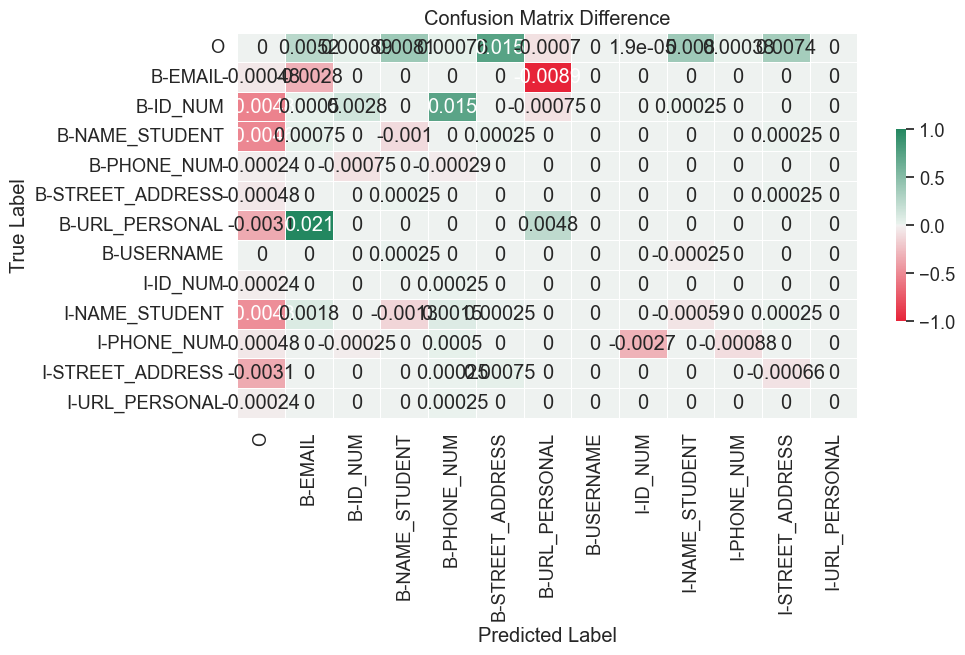

<Axes: title={'center': 'Confusion Matrix Difference'}, xlabel='Predicted Label', ylabel='True Label'>

In [255]:
visualize_diff_matrix(cont_matrix, classes, fmt = '.2g', invert_diagonal=False, invert_colors=False, robust=False)

## Class based summaries

### Experiment

In [257]:
def calculate_f_beta(tp, fp, fn, beta):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return f_beta

def compute_diff_cm(cm1, cm2):
    # Compute the difference in confusion matrices
    diff_cm = {}
    for class_label in cm1:
        diff_cm[class_label] = {}
        for inner_label in cm1[class_label]:
            diff_cm[class_label][inner_label] = cm2[class_label][inner_label] - cm1[class_label][inner_label]
    return diff_cm

def compute_f_beta_change(tp_change, fp_change, fn_change, beta):
    # Compute the change in F-beta score
    f_beta_change = calculate_f_beta(tp_change, fp_change, fn_change, beta)
    return f_beta_change

# Example confusion matrices
cm1 = {
    'Class 1': {'TP': 50, 'FP': 5, 'FN': 10},
    'Class 2': {'TP': 70, 'FP': 15, 'FN': 20}
}

cm2 = {
    'Class 1': {'TP': 60, 'FP': 10, 'FN': 5},
    'Class 2': {'TP': 80, 'FP': 10, 'FN': 15}
}

# Parameters
beta = 1

# Step 1: Calculate F-beta score for each confusion matrix
f_beta1 = calculate_f_beta(cm1['Class 1']['TP'], cm1['Class 1']['FP'], cm1['Class 1']['FN'], beta)
f_beta2 = calculate_f_beta(cm2['Class 1']['TP'], cm2['Class 1']['FP'], cm2['Class 1']['FN'], beta)

# Step 2: Compute the difference in F-beta scores
diff_f_beta = f_beta2 - f_beta1

# Step 3: Compute the difference in confusion matrices
diff_cm = compute_diff_cm(cm1, cm2)

# Step 4: Compute the change in F-beta score
f_beta_change = compute_f_beta_change(diff_cm['Class 1']['TP'], diff_cm['Class 1']['FP'], diff_cm['Class 1']['FN'], beta)

print("F-beta score for cm1:", f_beta1)
print("F-beta score for cm2:", f_beta2)
print("Difference in F-beta scores:", diff_f_beta)
print("Change in F-beta score:", f_beta_change)

F-beta score for cm1: 0.8695652173913043
F-beta score for cm2: 0.888888888888889
Difference in F-beta scores: 0.019323671497584627
Change in F-beta score: 1.0


In [ ]:
import numpy as np

def calculate_f_beta(tp, fp, fn, beta):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return f_beta

def compute_diff_cm(cm1, cm2):
    # Compute the difference in confusion matrices
    diff_cm = cm2 - cm1
    return diff_cm

def compute_f_beta_contributions(cm1, cm2, beta):
    # Compute the difference in confusion matrices
    diff_cm = compute_diff_cm(cm1, cm2)

    # Initialize matrix to store contributions
    n_classes = cm1.shape[0]
    f_beta_contributions = np.zeros((n_classes, 3))  # 3 columns for TP, FP, FN

    # Compute contribution of each class to F-beta score
    for i in range(n_classes):
        tp_change = diff_cm[i, 0]
        fp_change = diff_cm[i, 1]
        fn_change = diff_cm[i, 2]

        f_beta_change = calculate_f_beta(tp_change, fp_change, fn_change, beta)

        # Store contributions
        f_beta_contributions[i] = [tp_change * f_beta_change, fp_change * f_beta_change, fn_change * f_beta_change]

    return f_beta_contributions

# Example confusion matrices
cm1 = np.array([
    [50, 5, 10],
    [70, 15, 20]
])

cm2 = np.array([
    [60, 10, 5],
    [80, 10, 15]
])

# Parameters
beta = 1

# Compute contributions
f_beta_contributions = compute_f_beta_contributions(cm1, cm2, beta)
print("F-beta contributions for each class (TP, FP, FN):")
print(f_beta_contributions)

F-beta contributions for each class (TP, FP, FN):
[[ 10.   5.  -5.]
 [ 20. -10. -10.]]


In [262]:
cont_class_matrix = compute_f_beta_contributions(word_confusion_matrix_1, word_confusion_matrix_2, 5)

C:\Users\cloud\AppData\Local\Temp\ipykernel_8636\3559268454.py:4: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\cloud\AppData\Local\Temp\ipykernel_8636\3559268454.py:5: RuntimeWarning: invalid value encountered in scalar divide
  recall = tp / (tp + fn)


In [269]:
cont_class_matrix

array([[ 4.74258704e+03, -5.45842991e+02, -9.42168015e+01],
       [ 7.42857143e+00, -1.41142857e+02,  0.00000000e+00],
       [ 7.08446866e+00, -7.08446866e-01,  1.34604905e+01],
       [ 1.91160896e+01, -3.01832994e+00,  0.00000000e+00],
       [ 2.57425743e-01,  0.00000000e+00,  7.72277228e-01],
       [ 2.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.70310078e+01, -1.04806202e+02,  0.00000000e+00],
       [            nan,             nan,             nan],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.82733189e+01, -7.10629067e+00,  0.00000000e+00],
       [ 1.35064935e+00,  0.00000000e+00,  6.75324675e-01],
       [ 1.30000000e+01,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [270]:
cont_class_matrix[0][0]

4742.58703954139

<Axes: >

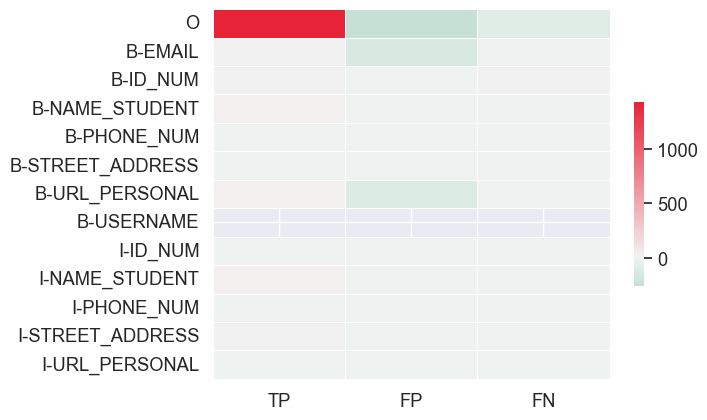

In [268]:
sns.heatmap(cont_class_matrix, robust=True, fmt="d", cmap=cmap, center=0,
        linewidths=.5, cbar_kws={"shrink": .5}, yticklabels=classes, xticklabels=['TP','FP','FN'])
    

In [272]:
def calculate_f_beta(tp, fp, fn, beta):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return f_beta

def compute_f_beta_contributions(cm1, cm2, beta):
    # Compute the difference in confusion matrices
    diff_cm = cm2 - cm1

    # Compute original F-beta score
    original_tp = np.sum(cm1[:, 0])
    original_fp = np.sum(cm1[:, 1])
    original_fn = np.sum(cm1[:, 2])
    original_f_beta = calculate_f_beta(original_tp, original_fp, original_fn, beta)

    # Initialize matrix to store contributions
    n_classes = cm1.shape[0]
    f_beta_contributions = np.zeros((n_classes, 3))  # 3 columns for TP, FP, FN

    # Compute contributions for each class
    for i in range(n_classes):
        tp_change = diff_cm[i, 0]
        fp_change = diff_cm[i, 1]
        fn_change = diff_cm[i, 2]

        # Compute F-beta score after modifying TP alone
        modified_tp = original_tp + tp_change
        modified_f_beta_tp = calculate_f_beta(modified_tp, original_fp, original_fn, beta)
        contribution_tp = modified_f_beta_tp - original_f_beta

        # Compute F-beta score after modifying FP alone
        modified_fp = original_fp + fp_change
        modified_f_beta_fp = calculate_f_beta(original_tp, modified_fp, original_fn, beta)
        contribution_fp = modified_f_beta_fp - original_f_beta

        # Compute F-beta score after modifying FN alone
        modified_fn = original_fn + fn_change
        modified_f_beta_fn = calculate_f_beta(original_tp, original_fp, modified_fn, beta)
        contribution_fn = modified_f_beta_fn - original_f_beta

        # Store contributions
        f_beta_contributions[i] = [contribution_tp, contribution_fp, contribution_fn]

    return f_beta_contributions

# Example confusion matrices
cm1 = np.array([
    [50, 5, 10],
    [70, 15, 20]
])

cm2 = np.array([
    [60, 10, 5],
    [80, 10, 15]
])

# Parameters
beta = 1

# Compute contributions
f_beta_contributions = compute_f_beta_contributions(cm1, cm2, beta)
print("F-beta contributions for each class (TP, FP, FN):")
print(f_beta_contributions)


F-beta contributions for each class (TP, FP, FN):
[[ 0.01112347 -0.01402688  0.01451906]
 [ 0.01112347  0.01451906  0.01451906]]


In [273]:
cont_class_matrix = compute_f_beta_contributions(word_confusion_matrix_1, word_confusion_matrix_2, 5)

In [274]:
cont_class_matrix[0][0]

2.2507694041884463e-08

In [281]:
cont_class_matrix.sum()

1.4794727005607022e-05

<Axes: >

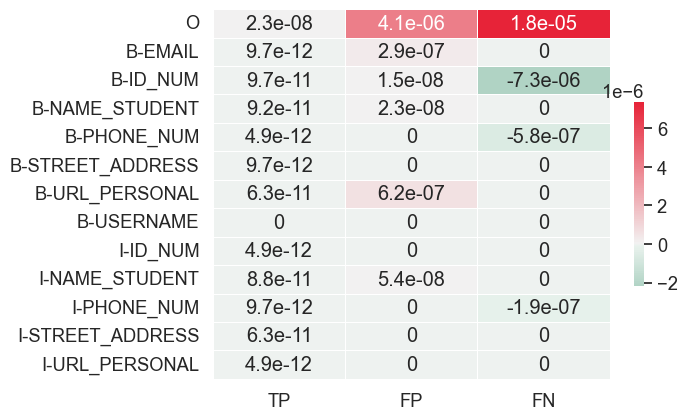

In [279]:
sns.heatmap(cont_class_matrix, annot=cont_class_matrix, robust=True, fmt='.2g', cmap=cmap, center=0,
        linewidths=.5, cbar_kws={"shrink": .5}, yticklabels=classes, xticklabels=['TP','FP','FN'])
    

In [262]:
cont_class_matrix = compute_f_beta_contributions(word_confusion_matrix_1, word_confusion_matrix_2, 5)

C:\Users\cloud\AppData\Local\Temp\ipykernel_8636\3559268454.py:4: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\cloud\AppData\Local\Temp\ipykernel_8636\3559268454.py:5: RuntimeWarning: invalid value encountered in scalar divide
  recall = tp / (tp + fn)


In [269]:
cont_class_matrix

array([[ 4.74258704e+03, -5.45842991e+02, -9.42168015e+01],
       [ 7.42857143e+00, -1.41142857e+02,  0.00000000e+00],
       [ 7.08446866e+00, -7.08446866e-01,  1.34604905e+01],
       [ 1.91160896e+01, -3.01832994e+00,  0.00000000e+00],
       [ 2.57425743e-01,  0.00000000e+00,  7.72277228e-01],
       [ 2.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.70310078e+01, -1.04806202e+02,  0.00000000e+00],
       [            nan,             nan,             nan],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.82733189e+01, -7.10629067e+00,  0.00000000e+00],
       [ 1.35064935e+00,  0.00000000e+00,  6.75324675e-01],
       [ 1.30000000e+01,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [270]:
cont_class_matrix[0][0]

4742.58703954139

<Axes: >

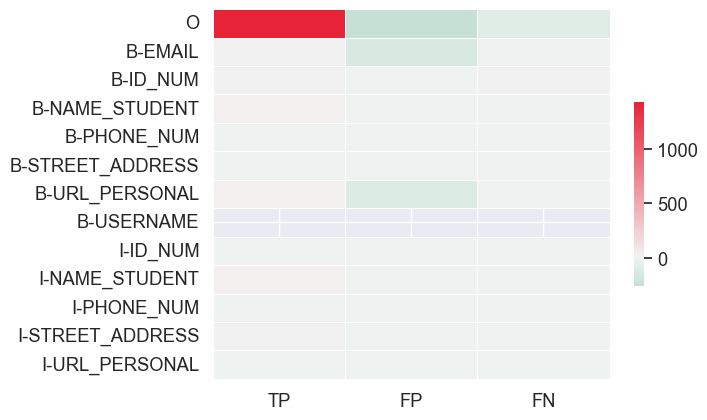

In [268]:
sns.heatmap(cont_class_matrix, robust=True, fmt="d", cmap=cmap, center=0,
        linewidths=.5, cbar_kws={"shrink": .5}, yticklabels=classes, xticklabels=['TP','FP','FN'])
    

In [262]:
cont_class_matrix = compute_f_beta_contributions(word_confusion_matrix_1, word_confusion_matrix_2, 5)

C:\Users\cloud\AppData\Local\Temp\ipykernel_8636\3559268454.py:4: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\cloud\AppData\Local\Temp\ipykernel_8636\3559268454.py:5: RuntimeWarning: invalid value encountered in scalar divide
  recall = tp / (tp + fn)


In [269]:
cont_class_matrix

array([[ 4.74258704e+03, -5.45842991e+02, -9.42168015e+01],
       [ 7.42857143e+00, -1.41142857e+02,  0.00000000e+00],
       [ 7.08446866e+00, -7.08446866e-01,  1.34604905e+01],
       [ 1.91160896e+01, -3.01832994e+00,  0.00000000e+00],
       [ 2.57425743e-01,  0.00000000e+00,  7.72277228e-01],
       [ 2.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.70310078e+01, -1.04806202e+02,  0.00000000e+00],
       [            nan,             nan,             nan],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.82733189e+01, -7.10629067e+00,  0.00000000e+00],
       [ 1.35064935e+00,  0.00000000e+00,  6.75324675e-01],
       [ 1.30000000e+01,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [270]:
cont_class_matrix[0][0]

4742.58703954139

<Axes: >

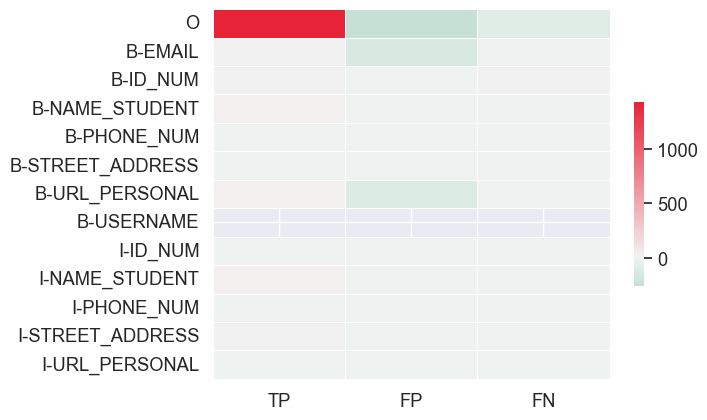

In [268]:
sns.heatmap(cont_class_matrix, robust=True, fmt="d", cmap=cmap, center=0,
        linewidths=.5, cbar_kws={"shrink": .5}, yticklabels=classes, xticklabels=['TP','FP','FN'])
    

### Modified

In [299]:
def calculate_f_beta(tp, fp, fn, beta):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return f_beta

def compute_f_beta_contributions(cm1, cm2, beta):
    diff_cm = cm2 - cm1
    n_classes = cm1.shape[0]
    f_beta_contributions = np.zeros((n_classes, 3))  # 3 columns for TP, FP, FN

    # Calculate original TP, FP, FN counts
    tp_orig = np.sum(np.diag(cm1))
    fp_orig = np.sum(cm1, axis=0) - np.diag(cm1)
    fn_orig = np.sum(cm1, axis=1) - np.diag(cm1)
    
    tp_orig = sum(TP[pos_labels])
    fp_orig = sum(FP[pos_labels])
    fn_orig = sum(FN[pos_labels])

    
    # Calculate original F-beta score
    original_f_beta = calculate_f_beta(tp_orig, fp_orig.sum(), fn_orig.sum(), beta)

    for i in range(n_classes):
        tp_change = diff_cm[i, i]
        fp_change = np.sum(diff_cm[:, i]) - tp_change
        fn_change = np.sum(diff_cm[i, :]) - tp_change

        # Calculate contributions
        f_beta_contributions[i] = [
            calculate_f_beta(tp_orig + tp_change, fp_orig[i] - fp_change, fn_orig[i] - fn_change, beta) - original_f_beta,
            calculate_f_beta(tp_orig - tp_change, fp_orig[i] + fp_change, fn_orig[i] - fn_change, beta) - original_f_beta,
            calculate_f_beta(tp_orig - tp_change, fp_orig[i] - fp_change, fn_orig[i] + fn_change, beta) - original_f_beta
        ]

    return f_beta_contributions

# Example confusion matrices
cm1 = np.array([
    [50, 5, 10],   # Class 0
    [7, 60, 20],   # Class 1
    [15, 20, 70]   # Class 2
])

cm2 = np.array([
    [60, 10, 5],   # Class 0
    [8, 60, 19],   # Class 1
    [14, 21, 70]   # Class 2
])

# Parameters
beta = 1

# Compute contributions
f_beta_contributions = compute_f_beta_contributions(cm1, cm2, beta)
print("F-beta contributions for each class (TP, FP, FN):")
print(f_beta_contributions)

F-beta contributions for each class (TP, FP, FN):
[[0.21088188 0.20146766 0.20146766]
 [0.1863104  0.16085491 0.1863104 ]
 [0.13487772 0.15879944 0.13487772]]


In [283]:
cont_class_matrix = compute_f_beta_contributions(word_confusion_matrix_1, word_confusion_matrix_2, 5)

C:\Users\cloud\AppData\Local\Temp\ipykernel_8636\1135524902.py:6: RuntimeWarning: invalid value encountered in scalar divide
  f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
C:\Users\cloud\AppData\Local\Temp\ipykernel_8636\1135524902.py:4: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [291]:
cont_class_matrix.sum()

nan

<Axes: >

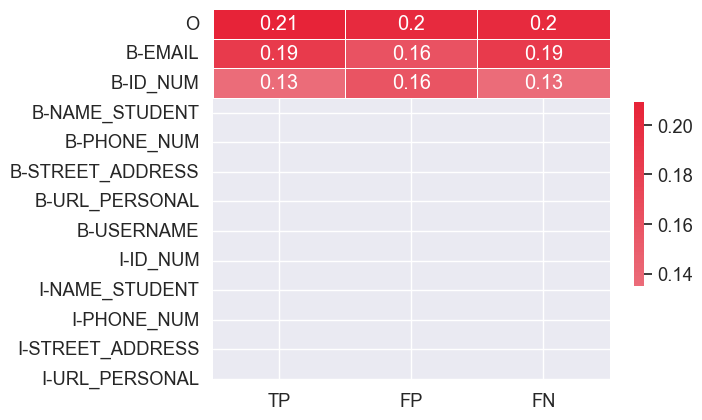

In [300]:
sns.heatmap(f_beta_contributions, annot=f_beta_contributions, robust=True, fmt='.2g', cmap=cmap, center=0,
        linewidths=.5, cbar_kws={"shrink": .5}, yticklabels=classes, xticklabels=['TP','FP','FN'])
    

In [ ]:
import numpy as np

def calculate_f_beta(tp, fp, fn, beta):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return f_beta

def compute_f_beta_contributions(cm1, cm2, beta):
    diff_cm = cm2 - cm1
    n_classes = cm1.shape[0]
    f_beta_contributions = np.zeros((n_classes, 3))  # 3 columns for TP, FP, FN

    for i in range(n_classes):
        # Calculate contributions for change in TP
        tp_change = diff_cm[i, i]
        f_beta_contributions[i, 0] = calculate_f_beta(np.diag(cm1)[i] + tp_change, np.sum(cm1, axis=0)[i] - np.sum(cm1[i, :]), np.sum(cm1, axis=1)[i] - np.sum(cm1[i, :]), beta)

        # Calculate contributions for change in FP
        fp_change = diff_cm[:, i].sum() - tp_change
        f_beta_contributions[i, 1] = calculate_f_beta(np.diag(cm1)[i], np.sum(cm1, axis=0)[i] + fp_change, np.sum(cm1, axis=1)[i], beta)

        # Calculate contributions for change in FN
        fn_change = diff_cm[i, :].sum() - tp_change
        f_beta_contributions[i, 2] = calculate_f_beta(np.diag(cm1)[i], np.sum(cm1, axis=0)[i], np.sum(cm1, axis=1)[i] + fn_change, beta)

    return f_beta_contributions

# Example confusion matrices
cm1 = np.array([
    [50, 5, 10],   # Class 0
    [7, 60, 20],   # Class 1
    [15, 20, 70]   # Class 2
])

cm2 = np.array([
    [60, 10, 5],   # Class 0
    [8, 60, 19],   # Class 1
    [14, 21, 70]   # Class 2
])

# Parameters
beta = 1

# Compute contributions
f_beta_contributions = compute_f_beta_contributions(cm1, cm2, beta)
print("F-beta contributions for each class (TP, FP, FN):")
print(f_beta_contributions)


In [289]:
cont_class_matrix.shape

(13, 3)

In [18]:
def calculate_f_beta(tp, fp, fn, beta):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return f_beta


def compute_f_beta_contributions(cm1, cm2, beta, class_index):
    diff_cm = cm2 - cm1
    n_classes = cm1.shape[0]
    f_beta_contributions = np.zeros((n_classes, 3))  # 3 columns for TP, FP, FN

    # Calculate the original F-beta score for the entire multiclass classification model using cm1
    tp_orig = sum(np.diag(cm1)[pos_classes])
    fp_orig = np.sum(cm1, axis=0) - tp_orig
    fn_orig = np.sum(cm1, axis=1) - tp_orig
    
    tp_orig = tp_orig[pos_classes]
    fp_orig = fp_orig[pos_classes]
    fn_orig = fn_orig[pos_classes]
    
    
    original_f_beta = calculate_f_beta(np.sum(tp_orig), np.sum(fp_orig), np.sum(fn_orig), beta)

    # Calculate contributions for changes in TP, FP, and FN separately
    for i in range(n_classes):
        # Simulate changes in TP, FP, and FN while keeping other metrics constant
        tp_change = diff_cm[i, i]
        fp_change = np.sum(diff_cm[:, i]) - tp_change
        fn_change = np.sum(diff_cm[i, :]) - tp_change

        # Calculate contributions for TP, FP, and FN separately
        f_beta_tp = calculate_f_beta(tp_orig[i] + tp_change, fp_orig[i], fn_orig[i], beta)
        f_beta_fp = calculate_f_beta(tp_orig[i], fp_orig[i] + fp_change, fn_orig[i], beta)
        f_beta_fn = calculate_f_beta(tp_orig[i], fp_orig[i], fn_orig[i] + fn_change, beta)

        # Calculate contributions by subtracting original F-beta score
        f_beta_contributions[i] = [
            f_beta_tp - original_f_beta,
            f_beta_fp - original_f_beta,
            f_beta_fn - original_f_beta
        ]

    return f_beta_contributions

# Example confusion matrices
cm1 = np.array([
    [50, 5, 10],   # Class 0
    [7, 60, 20],   # Class 1
    [15, 20, 70]   # Class 2
])

cm2 = np.array([
    [60, 10, 5],   # Class 0
    [8, 60, 19],   # Class 1
    [14, 21, 70]   # Class 2
])

# Parameters
beta = 1
class_index = 1  # Class index of interest (e.g., 0, 1, 2)

# Compute contributions for the specified class
f_beta_contributions = compute_f_beta_contributions(cm1, cm2, beta, class_index)
print(f"F-beta contributions for class {class_index} (TP, FP, FN):")
print(f_beta_contributions)

NameError: name 'pos_classes' is not defined

In [301]:
cont_class_matrix = compute_f_beta_contributions(word_confusion_matrix_1, word_confusion_matrix_2, 5)

In [304]:
cont_class_matrix

array([[-0.00074678, -0.00075311,  0.00103087],
       [ 0.00190254,  0.00191218,  0.00188787],
       [ 0.00188142,  0.00188278,  0.00189608],
       [ 0.00185755,  0.00187037,  0.00185215],
       [ 0.00190315,  0.00190543,  0.0019016 ],
       [ 0.00188075,  0.00190466,  0.00188075],
       [ 0.00187176,  0.00187003,  0.00189761],
       [ 0.00190389,  0.00190389,  0.00190389],
       [ 0.00190486,  0.00190472,  0.00190486],
       [ 0.00187003,  0.0018827 ,  0.00186694],
       [ 0.00190618,  0.00190678,  0.00190155],
       [ 0.00189288,  0.00190466,  0.00188941],
       [ 0.00190485,  0.00190485,  0.00190485]])

In [302]:
cont_class_matrix.sum()

0.06765143832707798

<Axes: >

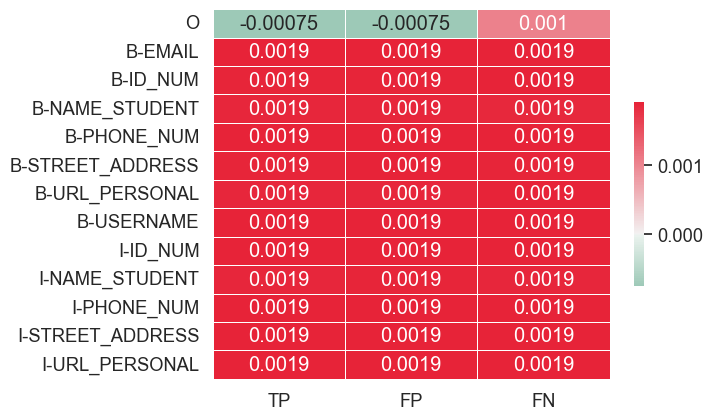

In [303]:
sns.heatmap(cont_class_matrix, annot=cont_class_matrix, robust=True, fmt='.2g', cmap=cmap, center=0,
        linewidths=.5, cbar_kws={"shrink": .5}, yticklabels=classes, xticklabels=['TP','FP','FN'])
    

<Axes: >

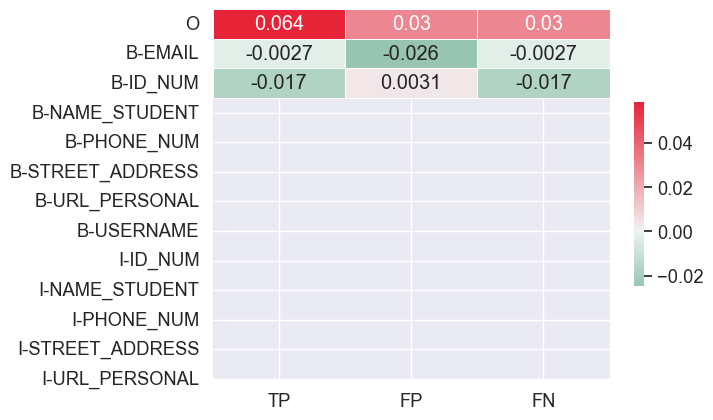

In [298]:
sns.heatmap(f_beta_contributions, annot=f_beta_contributions, robust=True, fmt='.2g', cmap=cmap, center=0,
        linewidths=.5, cbar_kws={"shrink": .5}, yticklabels=classes, xticklabels=['TP','FP','FN'])
    

In [ ]:
#1D Heatmap?

In [ ]:
#Research alternatives for mcnemar

### Latest

In [64]:
def calculate_f_beta(tp, fp, fn, beta):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return f_beta


def compute_f_beta_contributions(cm1, cm2, pos_labels, beta=5):
    diff_cm = cm2 - cm1
    n_classes = cm1.shape[0]
    f_beta_contributions = np.zeros((n_classes, 4))  # 3 columns for TP, FP, FN

    # Calculate the original F-beta score for the entire multiclass classification model using cm1
    tp_orig = np.diag(cm1)
    fp_orig = np.sum(cm1, axis=0) - tp_orig
    fn_orig = np.sum(cm1, axis=1) - tp_orig
    

    total_tp = sum(tp_orig[pos_labels])
    total_fp = sum(fp_orig[pos_labels])
    total_fn = sum(fn_orig[pos_labels])
    
    original_f_beta = calculate_f_beta(total_tp, total_fp, total_fn, beta)

    # Calculate contributions for changes in TP, FP, and FN separately
    for i in range(1, n_classes):
        # Simulate changes in TP, FP, and FN while keeping other metrics constant
        tp_change = diff_cm[i, i]
        fp_change = np.sum(diff_cm[:, i]) - tp_change
        fn_change = np.sum(diff_cm[i, :]) - tp_change
    
        # Calculate contributions for TP, FP, and FN separately
        
        f_beta_tp = calculate_f_beta(total_tp + tp_change, total_fp, total_fn, beta)
        f_beta_fp = calculate_f_beta(total_tp, total_fp + fp_change, total_fn, beta)
        f_beta_fn = calculate_f_beta(total_tp, total_fp, total_fn + fn_change, beta)
        f_beta_class = calculate_f_beta(total_tp + tp_change, total_fp + fp_change, total_fn + fn_change, beta)
        
                
        # Calculate contributions by subtracting original F-beta score
        f_beta_contributions[i] = [
            f_beta_tp - original_f_beta,
            f_beta_fp - original_f_beta,
            f_beta_fn - original_f_beta,
            f_beta_class - original_f_beta
        ]

    return f_beta_contributions

# Example confusion matrices
cm1 = np.array([
    [50, 5, 10],   # Class 0
    [7, 60, 20],   # Class 1
    [15, 20, 70]   # Class 2
])

cm2 = np.array([
    [60, 10, 5],   # Class 0
    [8, 60, 19],   # Class 1
    [14, 21, 70]   # Class 2
])

# Parameters
beta = 1
class_index = 1  # Class index of interest (e.g., 0, 1, 2)

# Compute contributions for the specified class
f_beta_contributions = compute_f_beta_contributions(cm1, cm2, pos_labels= [0,1,2], beta=beta)
print(f"F-beta contributions for class {class_index} (TP, FP, FN):")
print(f_beta_contributions)

F-beta contributions for class 1 (TP, FP, FN):
[[ 0.          0.          0.          0.        ]
 [ 0.         -0.00808141  0.         -0.00808141]
 [ 0.          0.00827231  0.          0.00827231]]


In [67]:
cont_class_matrix = compute_f_beta_contributions(word_confusion_matrix_1, word_confusion_matrix_2, pos_labels=classes_pos_id,beta=5)

In [39]:
diff_cm

array([[ 4631,  -533,   -92,  -834,   -79, -1544,    73,     0,    -2,
         -821,   -39,  -760,     0],
       [    2,   -38,     0,     0,     0,     0,    36,     0,     0,
            0,     0,     0,     0],
       [   20,    -2,    38,     0,   -58,     0,     3,     0,     0,
           -1,     0,     0,     0],
       [   19,    -3,     0,   -14,     0,    -1,     0,     0,     0,
            0,     0,    -1,     0],
       [    1,     0,     3,     0,    -4,     0,     0,     0,     0,
            0,     0,     0,     0],
       [    2,     0,     0,    -1,     0,     0,     0,     0,     0,
            0,     0,    -1,     0],
       [   13,   -80,     0,     0,     0,     0,    67,     0,     0,
            0,     0,     0,     0],
       [    0,     0,     0,    -1,     0,     0,     0,     0,     0,
            1,     0,     0,     0],
       [    1,     0,     0,     0,    -1,     0,     0,     0,     0,
            0,     0,     0,     0],
       [   18,    -7,     0,

In [54]:
cont_class_matrix.sum()

4.032234826145675e-05

<Axes: >

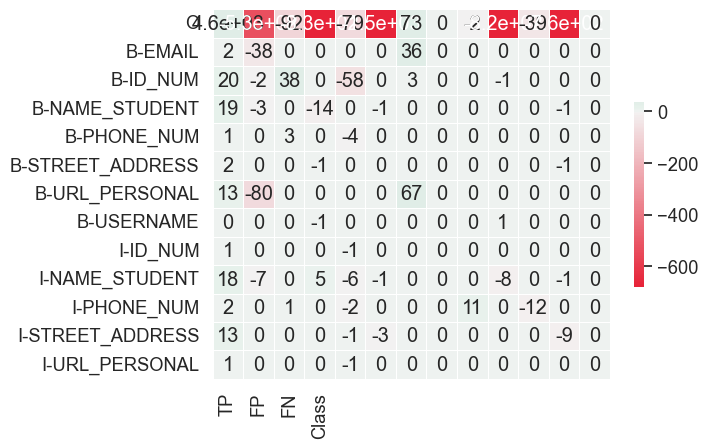

In [65]:
cmap = sns.diverging_palette(10, 150, s=90, l=50, as_cmap=True)

sns.heatmap(diff_cm, annot=diff_cm, robust=True, fmt='.2g', cmap=cmap, center=0,
        linewidths=.5, cbar_kws={"shrink": .5}, yticklabels=classes, xticklabels=['TP','FP','FN', 'Class'])
    

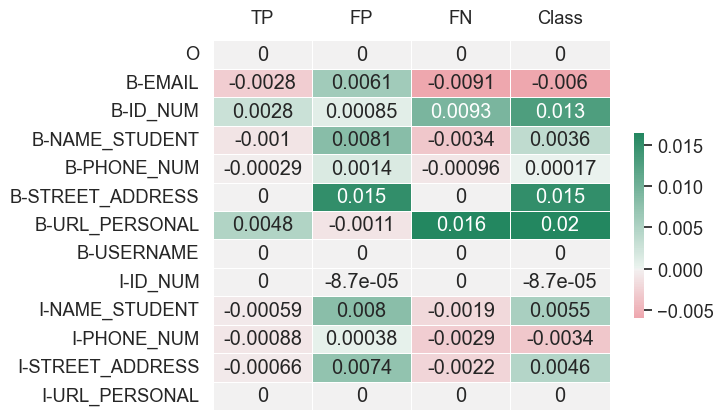

In [76]:
cmap = sns.diverging_palette(10, 150, s=90, l=50, as_cmap=True)

sns.heatmap(cont_class_matrix, annot=cont_class_matrix, robust=True, fmt='.2g', cmap=cmap, center=0,
        linewidths=.5, cbar_kws={"shrink": .5}, yticklabels=classes, xticklabels=['TP','FP','FN', 'Class'])


plt.tick_params(labelbottom = False, labeltop=True)
plt.show()
    

# Experiments

## Label exclusion on metric

### Orig

In [319]:
def compute_metrics_base(eval_preds, preprocessed_dataset, model_adapter, threshold = 0.1, return_processed=False):
    
    global flat_label_ids, list_word_true_labels
    
    np_probs, true_labels_id, inputs = eval_preds
    
    #---- Token Preds
    np_label_ids, flat_true_labels_id, flat_label_ids = get_tokens_thresholding(np_probs, true_labels_id, threshold, model_adapter)

    #---- Word Preds

    list_word_ids = [[word_id if word_id is not None else -100 for word_id in word_ids] for word_ids in preprocessed_dataset['word_ids'] ]
    word_ids_padded = pad_lists(list_word_ids, -100,  np_probs.shape[1])
    
    list_pred_words = get_word_preds(np_label_ids, word_ids_padded, model_adapter, preprocessed_dataset)
     
    #Overrides BIO if id already in BIO (BIO -> Entity -> BIO) or (non-BIO -> Entity -> BIO)
    #- implemented inside get_word_preds
    
#     list_pred_words_mapped = [to_bio_vect(pred_words,  model_adapter.np_model_id2cur_entity_id) for pred_words in list_pred_words]
    
    flat_word_label_ids = np.concatenate(list_pred_words)
    
    list_word_true_labels = preprocessed_dataset['word_labels']
    
    flat_word_true_labels_id = np.array([classes2id[word] for list_words in list_word_true_labels for word in list_words], dtype='int8')
    
 
    total_metrics, class_metrics, confusion_matrix = compute_micro_metrics(predictions = flat_label_ids, labels = flat_true_labels_id, 
                                                                       #    num_classes = len(model_adapter.labels), pos_labels=model_adapter.label_pos_ids, beta=5, prefix='token_')
                                                                            num_classes = model_adapter.n_token_labels, pos_labels=model_adapter.label_pos_ids, beta=5, prefix='token_')
    
    total_metrics_w, class_metrics_w, confusion_matrix_w = compute_micro_metrics(predictions = flat_word_label_ids, labels = flat_word_true_labels_id, 
                                                                                 num_classes = len(classes), pos_labels=classes_pos_id, beta=5, prefix='word_')
    
    dict_scores = {'token_confusion_matrix' : confusion_matrix,
                  'word_confusion_matrix' : confusion_matrix_w,
                   'token_total_metrics' : total_metrics,
                   'word_total_metrics' : total_metrics_w}
    
    dict_scores.update(class_metrics)
    dict_scores.update(class_metrics_w)

#     dict_scores = {}

    if return_processed:
        dict_processed = {'flat_label_ids' : flat_label_ids,
                  'flat_true_labels_id' : flat_true_labels_id,
                   'flat_word_label_ids' : flat_word_label_ids,
                   'flat_word_true_labels_id' : flat_word_true_labels_id}
        
        return dict_scores, dict_processed
    
    return dict_scores

In [307]:
def compute_micro_metrics(predictions, labels, num_classes, pos_labels, prefix='', beta=5):
#     global class_metrics
    
    
    confusion_matrix, TP, TN, FN, FP = count_confusion_matrix(predictions = predictions, labels = labels, num_classes = num_classes)
    
    class_metrics = {f'{prefix}{class_label}':compute_metrics_per_class(TP, FN, FP, class_label, beta=beta) for class_label in range(num_classes)}
#     class_metrics = {key:value for class_label in range(num_classes) for key,value in compute_metrics_per_class(TP, FN, FP, class_label, beta=beta, prefix=prefix).items()}
    
    
    # Calculate total true positives, false positives, and false negatives excluding 'O' label
    total_tp = sum(TP[pos_labels])
    total_fp = sum(FP[pos_labels])
    total_fn = sum(FN[pos_labels])
    
    # Compute total precision excluding 'O' label
    total_precision = total_tp / (total_tp + total_fp) if total_tp + total_fp > 0 else 0
    
    # Compute total recall excluding 'O' label
    total_recall = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0
    
    # Compute total F-beta score excluding 'O' label
    total_f_beta = (1 + beta**2) * (total_precision * total_recall) / (beta**2 * total_precision + total_recall) if total_precision + total_recall > 0 else 0
    
    total_metrics = {'precision':total_precision, 'recall':total_recall, 'f_beta':total_f_beta,'tp':total_tp, 'fp':total_fp, 'fn':total_fn}
    
    return total_metrics, class_metrics, confusion_matrix


### Test

In [315]:
def compute_micro_metrics(predictions, labels, num_classes, pos_labels, prefix='', beta=5):
#     global class_metrics
    
    
    confusion_matrix, TP, TN, FN, FP = count_confusion_matrix(predictions = predictions, labels = labels, num_classes = num_classes)
    
    class_metrics = {f'{prefix}{class_label}':compute_metrics_per_class(TP, FN, FP, class_label, beta=beta) for class_label in range(num_classes)}
#     class_metrics = {key:value for class_label in range(num_classes) for key,value in compute_metrics_per_class(TP, FN, FP, class_label, beta=beta, prefix=prefix).items()}
    
    
    # Calculate total true positives, false positives, and false negatives excluding 'O' label
    total_tp = sum(TP[pos_labels])
#     total_fp = sum(FP[pos_labels])
#     total_fn = sum(FN[pos_labels])

    total_fp = sum(FP)
    total_fn = sum(FN)
    
    # Compute total precision excluding 'O' label
    total_precision = total_tp / (total_tp + total_fp) if total_tp + total_fp > 0 else 0
    
    # Compute total recall excluding 'O' label
    total_recall = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0
    
    # Compute total F-beta score excluding 'O' label
    total_f_beta = (1 + beta**2) * (total_precision * total_recall) / (beta**2 * total_precision + total_recall) if total_precision + total_recall > 0 else 0
    
    total_metrics = {'precision':total_precision, 'recall':total_recall, 'f_beta':total_f_beta,'tp':total_tp, 'fp':total_fp, 'fn':total_fn}
    
    return total_metrics, class_metrics, confusion_matrix


In [321]:
%%time
df_all_metrics_2_test, token_confusion_matrix_2_test,  word_confusion_matrix_2_test = run_and_compute_metrics(path_dataset_2, path_preds_2, model_adapter_2)

CPU times: total: 1min 5s
Wall time: 1min 8s


In [322]:
df_all_metrics_2

,precision,recall,f_beta,tp,fp,fn
token_total_metrics,0.343886,0.665523,0.642413,3878.0,7399.0,1949.0
word_total_metrics,0.343371,0.878423,0.828754,2406.0,4601.0,333.0
token_O,0.999695,0.998543,0.998588,4725634.0,1444.0,6894.0
token_B-EMAIL,0.000000,0.000000,0.000000,0.0,0.0,263.0
token_B-ID_NUM,0.703008,0.502688,0.508258,187.0,79.0,185.0
token_B-NAME_STUDENT,0.323795,0.838879,0.790513,1437.0,3001.0,276.0
token_B-PHONE_NUM,0.000000,0.000000,0.000000,0.0,0.0,11.0
token_B-STREET_ADDRESS,0.000000,0.000000,0.000000,0.0,0.0,2.0
token_B-URL_PERSONAL,0.365321,0.464155,0.459375,887.0,1541.0,1024.0
token_B-USERNAME,0.000000,0.000000,0.000000,0.0,0.0,20.0


In [324]:
df_all_metrics_2_test

,precision,recall,f_beta,tp,fp,fn
token_total_metrics,0.304850,0.304850,0.304850,3878.0,8843.0,8843.0
word_total_metrics,0.331131,0.331131,0.331131,2406.0,4860.0,4860.0
token_O,0.999695,0.998543,0.998588,4725634.0,1444.0,6894.0
token_B-EMAIL,0.000000,0.000000,0.000000,0.0,0.0,263.0
token_B-ID_NUM,0.703008,0.502688,0.508258,187.0,79.0,185.0
token_B-NAME_STUDENT,0.323795,0.838879,0.790513,1437.0,3001.0,276.0
token_B-PHONE_NUM,0.000000,0.000000,0.000000,0.0,0.0,11.0
token_B-STREET_ADDRESS,0.000000,0.000000,0.000000,0.0,0.0,2.0
token_B-URL_PERSONAL,0.365321,0.464155,0.459375,887.0,1541.0,1024.0
token_B-USERNAME,0.000000,0.000000,0.000000,0.0,0.0,20.0


# Bin

In [ ]:
np_preds_1 = np.load("./in/preds01.npy")

In [ ]:
np_labels = pad_lists(dataset['labels'], -100, np_preds_1.shape[1])

In [ ]:
threshold = 0.18
# model_adapter = Yanis_Adapter(threshold = threshold, config_only=True, will_bio_tokens=True, will_bio_words=True)
compute_metrics_1 = functools.partial(compute_metrics_base, preprocessed_dataset=dataset_1, model_adapter=model_adapter_1, threshold=threshold)

In [ ]:
%%time
eval_preds = (np_preds_1, np_labels_1, None)
dict_all_scores_1 = compute_metrics_1(eval_preds)

In [ ]:
token_confusion_matrix_1 = dict_all_scores_1.pop('token_confusion_matrix')
word_confusion_matrix_1 = dict_all_scores_1.pop('word_confusion_matrix')

### will_bio_tokens = False = will_bio_words = True

In [ ]:
%%time
df_all_metrics = pd.DataFrame(dict_all_scores)
df_all_metrics.columns = df_all_metrics.columns.map(col_id2label)
df_all_metrics = df_all_metrics.T
df_all_metrics